In [1]:
# Python packages and utilities
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

try:
    import mlxtend
except ModuleNotFoundError:
    !pip install mlxtend

#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs

# Mordred
try:
    import mordred
    from mordred import Calculator, descriptors
except ModuleNotFoundError:
    !pip install 'mordred[full]'
    import mordred
    from mordred import Calculator, descriptors
    

# scikit-learn
try:
    import sklearn
except ModuleNotFoundError:
    !pip install -U scikit-learn
    import sklearn
    
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#imbalenced learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
except ModuleNotFoundError:
    !pip install -U imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN

# seaborn
try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt

#PIL
from PIL import Image

# scikitplot library
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip install scikit-plot
    import scikitplot as skplt

!pip install pip install -U imbalanced-learn

# own module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Modules import classification_metrics as cmetrics
from Modules import finger_prints as fp
from Modules import molecules_and_images as mo
from Modules import plotting_sklearn as pltsk
from Modules import classification_workflow_functions as cwf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Load target data

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

In [5]:
data = pd.read_csv("dftset2/set2ReactionMatrix.csv",header=None)

In [6]:
data

,0,1,2,3,4,...,49,50,51,52,53
0,-5.24,-1.150,0.0863,-0.0524,-0.04670,...,1.7,3.15,3.34,1.88,2.02
1,-4.70,-0.976,0.0886,-0.0488,-0.07500,...,1.7,3.15,3.34,1.88,2.02
2,-5.79,-1.350,0.0862,-0.0520,-0.06470,...,1.7,3.15,3.34,1.88,2.02
3,-5.12,-1.560,0.0952,-0.0495,-0.05670,...,1.7,3.15,3.34,1.88,2.02
4,-5.06,-0.981,0.0863,-0.0492,-0.02980,...,1.7,3.15,3.34,1.88,2.02
...,...,...,...,...,...,...,...,...,...,...,...
85,-4.77,-1.340,0.1210,-0.0496,-0.00268,...,1.7,3.15,3.34,1.88,2.02
86,-4.83,-1.290,0.0936,-0.0503,-0.00939,...,1.7,3.15,3.34,1.88,2.02
87,-4.89,-1.350,0.1260,-0.0519,-0.00373,...,1.7,3.15,3.34,1.88,2.02
88,-4.90,-1.330,0.1240,-0.0527,-0.00403,...,1.7,3.15,3.34,1.88,2.02


In [7]:
ddg = pd.read_csv("DDGset2.csv",header=None)

In [8]:
ddg

,0
0,0.000000
1,0.000000
2,1.426491
3,0.696565
4,3.194526
...,...
85,4.957045
86,4.088429
87,5.156630
88,6.314769


# Classify Molecules

In [9]:
classes=[]
for index, value in ddg[0].items():
    if value < 4:
        classes.append(0)
    else:
        classes.append(1)

In [10]:
classes
class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
features_and_classes_df = data.copy()
features_and_classes_df["classes"] = classes
feature_types = "no_categorical"

## Using synthetic data sampling

In this section I investigate the use of synthetic sampling methods, i.e. generate additional sampling points for the minority class or undersample the majority class. Both of these techniques look to provide a better balence between the classes and hence improve the learning of a decision boundary. SMOTE https://arxiv.org/pdf/1106.1813.pdf.


In [11]:
nneighbours = min(5, len(class_targets_df[class_targets_df["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=catagorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


Check that there are only features in the feature dataframe and classes in the classes dataframe.

In [12]:
log.info("Feature decriptions:\n{}".format(data.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df.columns.values))

Feature decriptions:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]
Classes/Targets descriptions:
['classes']


Sample using smote to balence the dataset using synthetic samples for the under represented class.

In [13]:
features_smote, classes_smote = sm.fit_resample(data.to_numpy(), class_targets_df.to_numpy())
n_sythetic_points = features_smote.shape[0] - len(data.index)
log.info("SMOTE has added {} sythetic features to balence the classes".format(n_sythetic_points))

SMOTE has added 22 sythetic features to balence the classes


In [14]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote, features_smote.shape, classes_smote, classes_smote.shape))

Resampled X
[[-5.24       -1.15        0.0863     ...  3.34        1.88
   2.02      ]
 [-4.7        -0.976       0.0886     ...  3.34        1.88
   2.02      ]
 [-5.79       -1.35        0.0862     ...  3.34        1.88
   2.02      ]
 ...
 [-4.72       -1.16        0.0943     ...  4.90076541  2.59079145
   3.16680739]
 [-4.72       -1.16        0.0943     ...  6.8         2.57465641
   9.41556758]
 [-4.72       -1.16        0.0943     ...  8.78562441  2.66226414
   6.38300384]]
(112, 54)
Resampled y:
[0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0
 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
(112,)


In [15]:
features_smote_df = pd.DataFrame(data=features_smote, columns=data.columns.values)
classes_smote_df = pd.DataFrame(data=classes_smote, columns=["classes"])

comb_df_res = features_smote_df.copy()
comb_df_res["classes"] = classes_smote
comb_df_res.to_csv("resampled_synthetic_data_set.csv")
comb_df_res

,0,1,2,3,4,...,50,51,52,53,classes
0,-5.240000,-1.150000,0.086300,-0.05240,-0.046700,...,3.150000,3.340000,1.880000,2.020000,0
1,-4.700000,-0.976000,0.088600,-0.04880,-0.075000,...,3.150000,3.340000,1.880000,2.020000,0
2,-5.790000,-1.350000,0.086200,-0.05200,-0.064700,...,3.150000,3.340000,1.880000,2.020000,0
3,-5.120000,-1.560000,0.095200,-0.04950,-0.056700,...,3.150000,3.340000,1.880000,2.020000,0
4,-5.060000,-0.981000,0.086300,-0.04920,-0.029800,...,3.150000,3.340000,1.880000,2.020000,0
...,...,...,...,...,...,...,...,...,...,...,...
107,-4.720000,-1.160000,0.094300,-0.04780,-0.008940,...,0.359038,10.060130,3.446029,9.766613,0
108,-5.644869,-1.268987,0.085983,-0.05174,-0.056577,...,3.150000,3.340000,1.880000,2.020000,0
109,-4.720000,-1.160000,0.094300,-0.04780,-0.008940,...,0.322454,4.900765,2.590791,3.166807,0
110,-4.720000,-1.160000,0.094300,-0.04780,-0.008940,...,2.020000,6.800000,2.574656,9.415568,0


## Using balenced classes Kfold
This section tests the relience of the model on the training set

In [16]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "Decision Tree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

Features: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53],
           dtype='int64')
Features:            0         1         2        3         4         5        6     7   \
0   -5.240000 -1.150000  0.086300 -0.05240 -0.046700  4.800000  4.27000  3.04   
1   -4.700000 -0.976000  0.088600 -0.04880 -0.075000  3.700000  4.28000  2.27   
2   -5.790000 -1.350000  0.086200 -0.05200 -0.064700  3.170000  4.32000  3.05   
3   -5.120000 -1.560000  0.095200 -0.04950 -0.056700  4.150000  4.29000  1.93   
4   -5.060000 -0.981000  0.086300 -0.04920 -0.029800  6.040000  4.27000  3.12   
..        ...       ...       ...      ...       ...       ...      ...   ...   
107 -4.720000 -1.160000  0.094300 -0.04780 -0.008940  3.390000  4.31000  2.09   
108 -5.644869 -1.268987  0.085983 -0.0517

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
	Best parameters; {'n_neighbors': 

	 Index | Predicted | Label
	------------------
	16   |   1   |   1
	30   |   0   |   0
	32   |   0   |   0
	35   |   1   |   1
	37   |   0   |   0
	58   |   1   |   0
	59   |   0   |   1
	60   |   1   |   0
	68   |   0   |   0
	94   |   0   |   0
	98   |   0   |   0
-----

----- Nearest_Neighbors: Fold 5 -----
[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  96  97  98
  99 100 101 103 104 106 107 108 109 110 111]
	Test indx: [ 11  13  17  19  28  45  74  76  91 102 105]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-define

	Best parameters; {'n_neighbors': 9}
	0.6599 (+/-0.1939) for {'n_neighbors': 2}
	0.6377 (+/-0.1978) for {'n_neighbors': 3}
	0.6397 (+/-0.2226) for {'n_neighbors': 4}
	0.6346 (+/-0.2301) for {'n_neighbors': 5}
	0.6286 (+/-0.2259) for {'n_neighbors': 6}
	0.6315 (+/-0.2166) for {'n_neighbors': 7}
	0.6477 (+/-0.2023) for {'n_neighbors': 8}
	0.6659 (+/-0.1925) for {'n_neighbors': 9}

	----- Predicting using: Nearest_Neighbors -----
	ROC analysis area under the curve: 0.65
	Confusion matrix (Nearest_Neighbors):
[[5 5]
 [0 1]]


	score (Nearest_Neighbors): 0.5454545454545454
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.50      1.00      0.67      0.71      0.48        10
          1       0.17      1.00      0.50      0.29      0.71      0.53         1

avg / total       0.92      0.55      0.95      0.63      0.71      0.48        11

	 Index | Predicted | Label
	-------

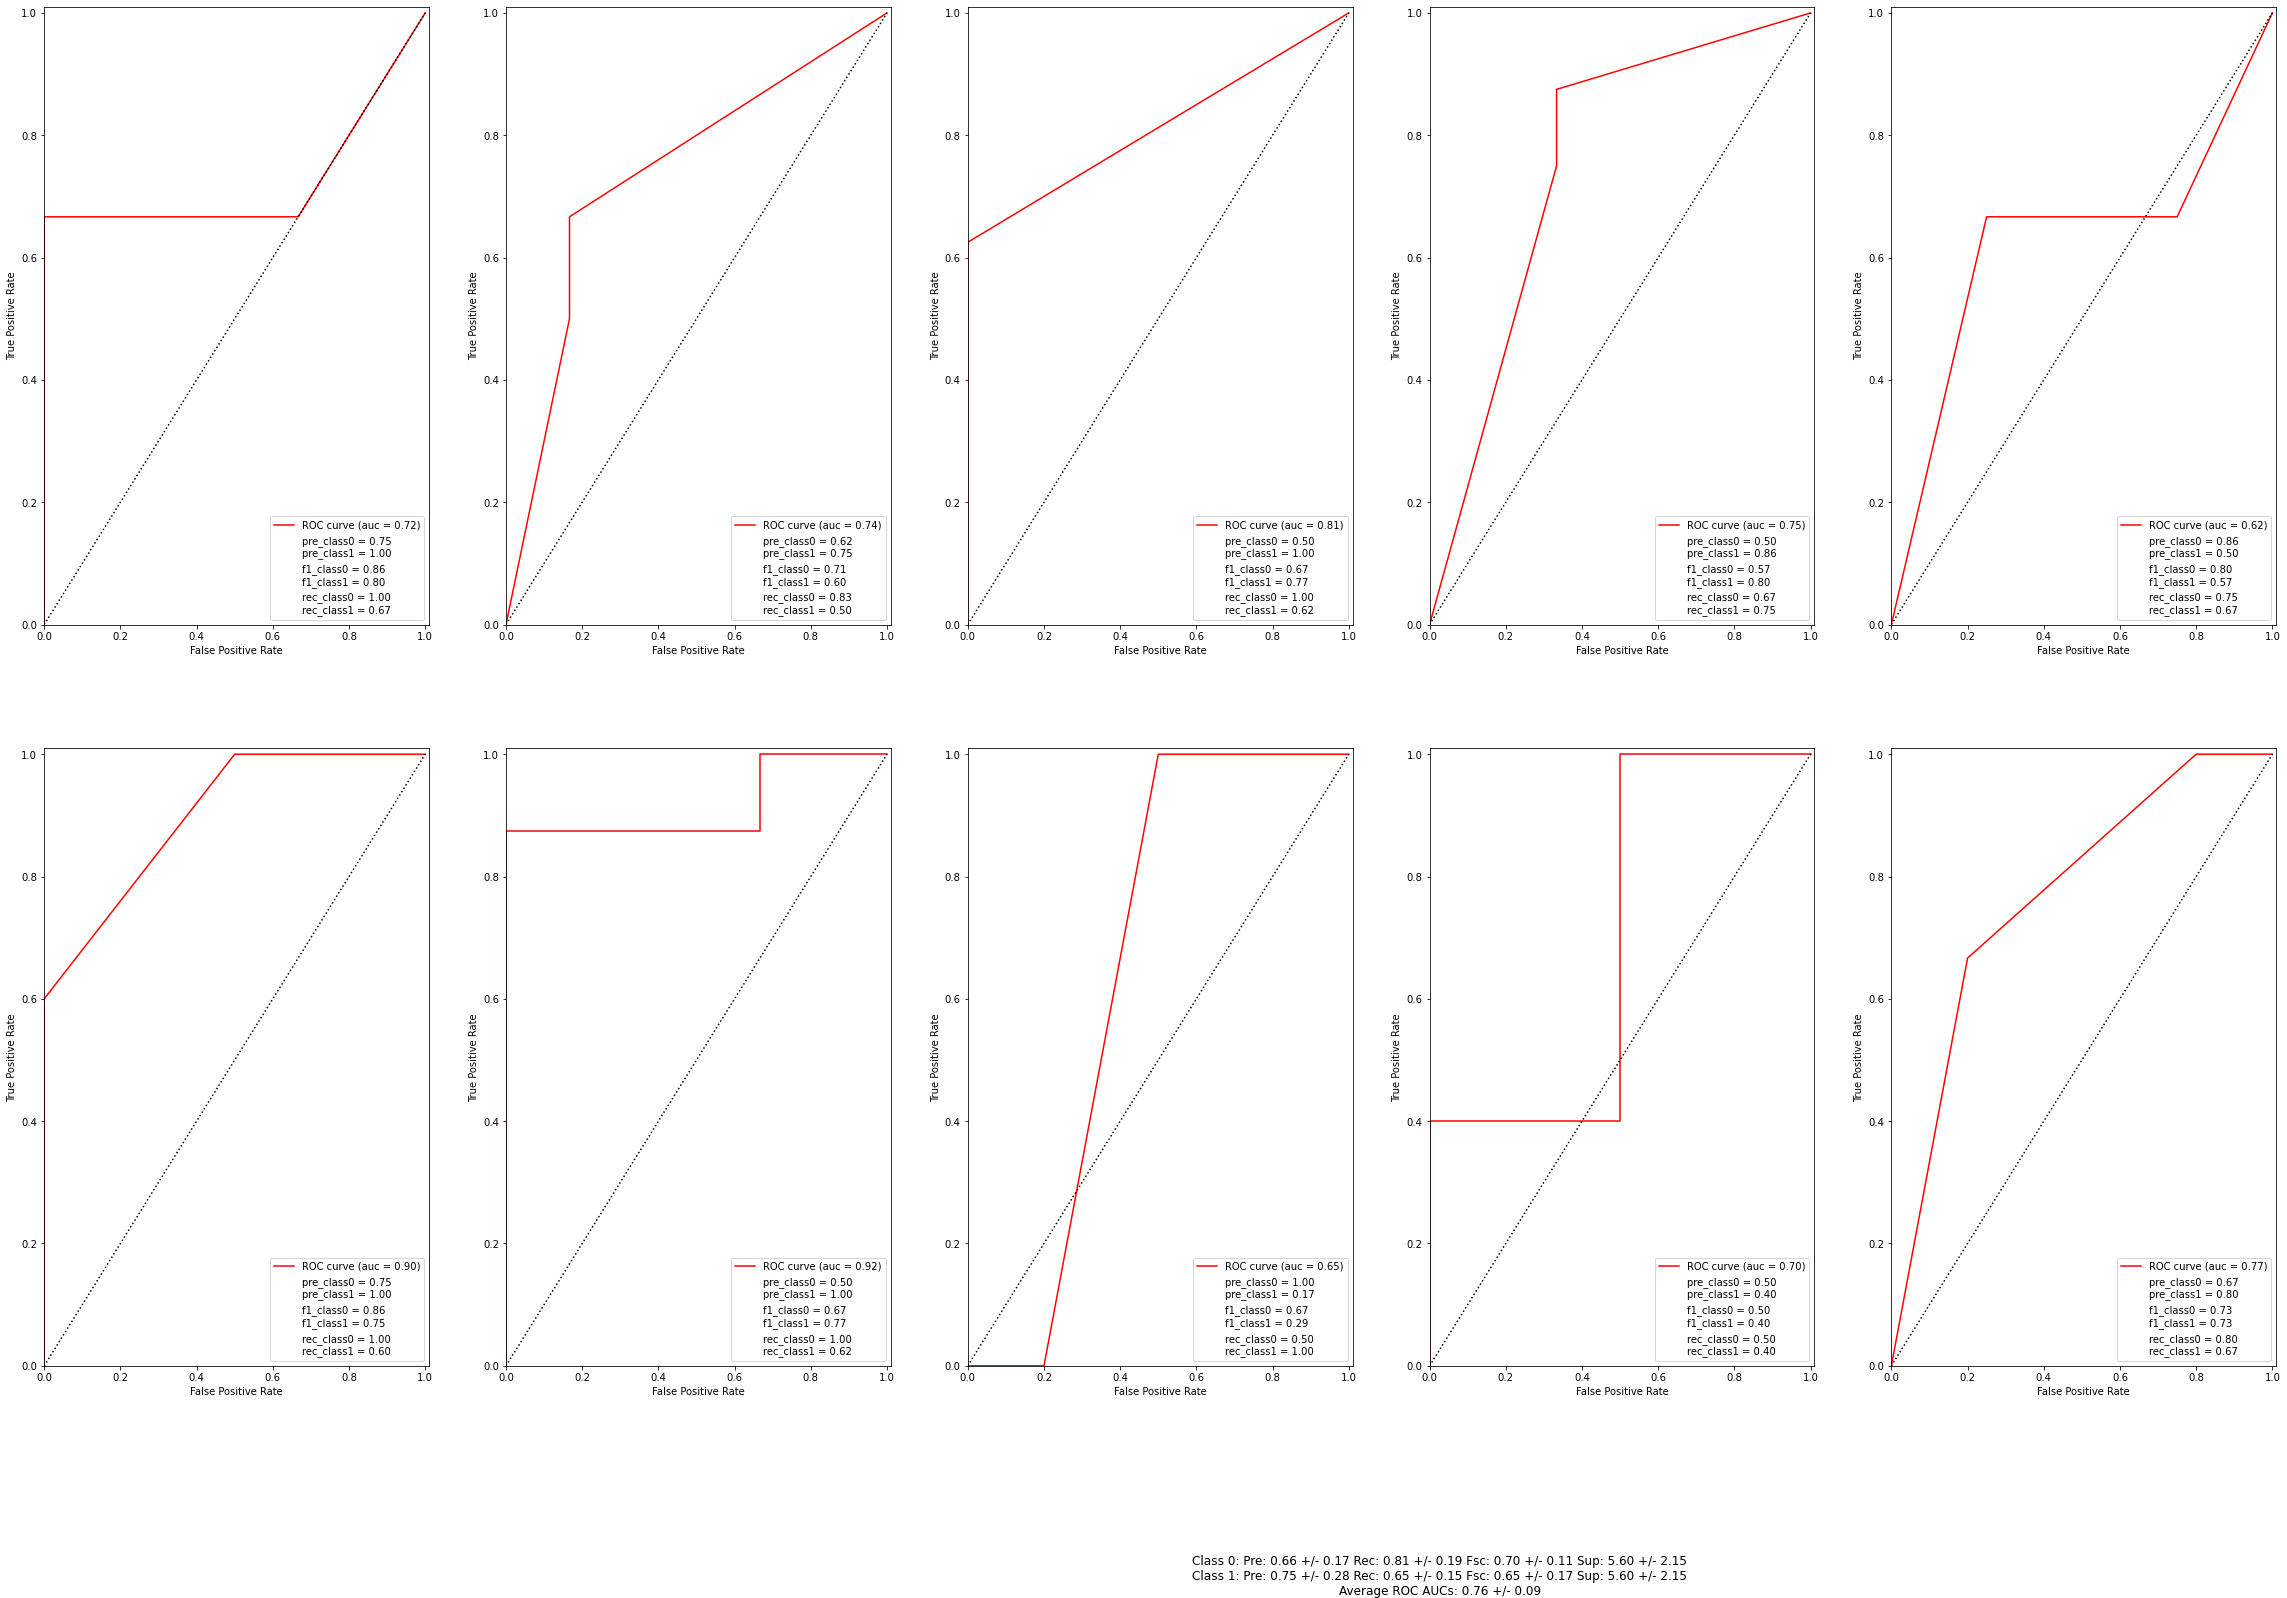


-----
Begin Gaussian Process
-----

----- Gaussian_Process: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/skl

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
	Best parameters; {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.7929 (+/-0.1240) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.7929 (+/-0.1250) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.7590 (+/-0.1366) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.7651 (+/-0.1393) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: Gaussian_Process -----
	ROC analysis area under the curve: 0.8333333333333333
	Confusion matrix (Gaussian_Process):
[[2 1]
 [3 5]]


	score (Gaussian_Process): 0.6363636363636364
	Imbalence reports:
	Imbalence classification report:
                   pre       rec

[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  96  97  98
  99 100 101 103 104 106 107 108 109 110 111]
	Test indx: [ 11  13  17  19  28  45  74  76  91 102 105]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is i

	0.7113 (+/-0.1471) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: Gaussian_Process -----
	ROC analysis area under the curve: 0.9166666666666667
	Confusion matrix (Gaussian_Process):
[[3 0]
 [2 6]]


	score (Gaussian_Process): 0.8181818181818182
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.60      1.00      0.75      0.75      0.87      0.77         3
          1       1.00      0.75      1.00      0.86      0.87      0.73         8

avg / total       0.89      0.82      0.93      0.83      0.87      0.74        11

	 Index | Predicted | Label
	------------------
	3   |   0   |   0
	7   |   0   |   1
	23   |   1   |   1
	26   |   1   |   1
	38   |   1   |   1
	40   |   1   |   1
	41   |   0   |   1
	85   |   1   |   1
	86   |   1   |   1
	95   |   0   |   0
	96   |   0   |   0
-----

----- Gaussian_Process: Fold 7 -----
[2

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceW

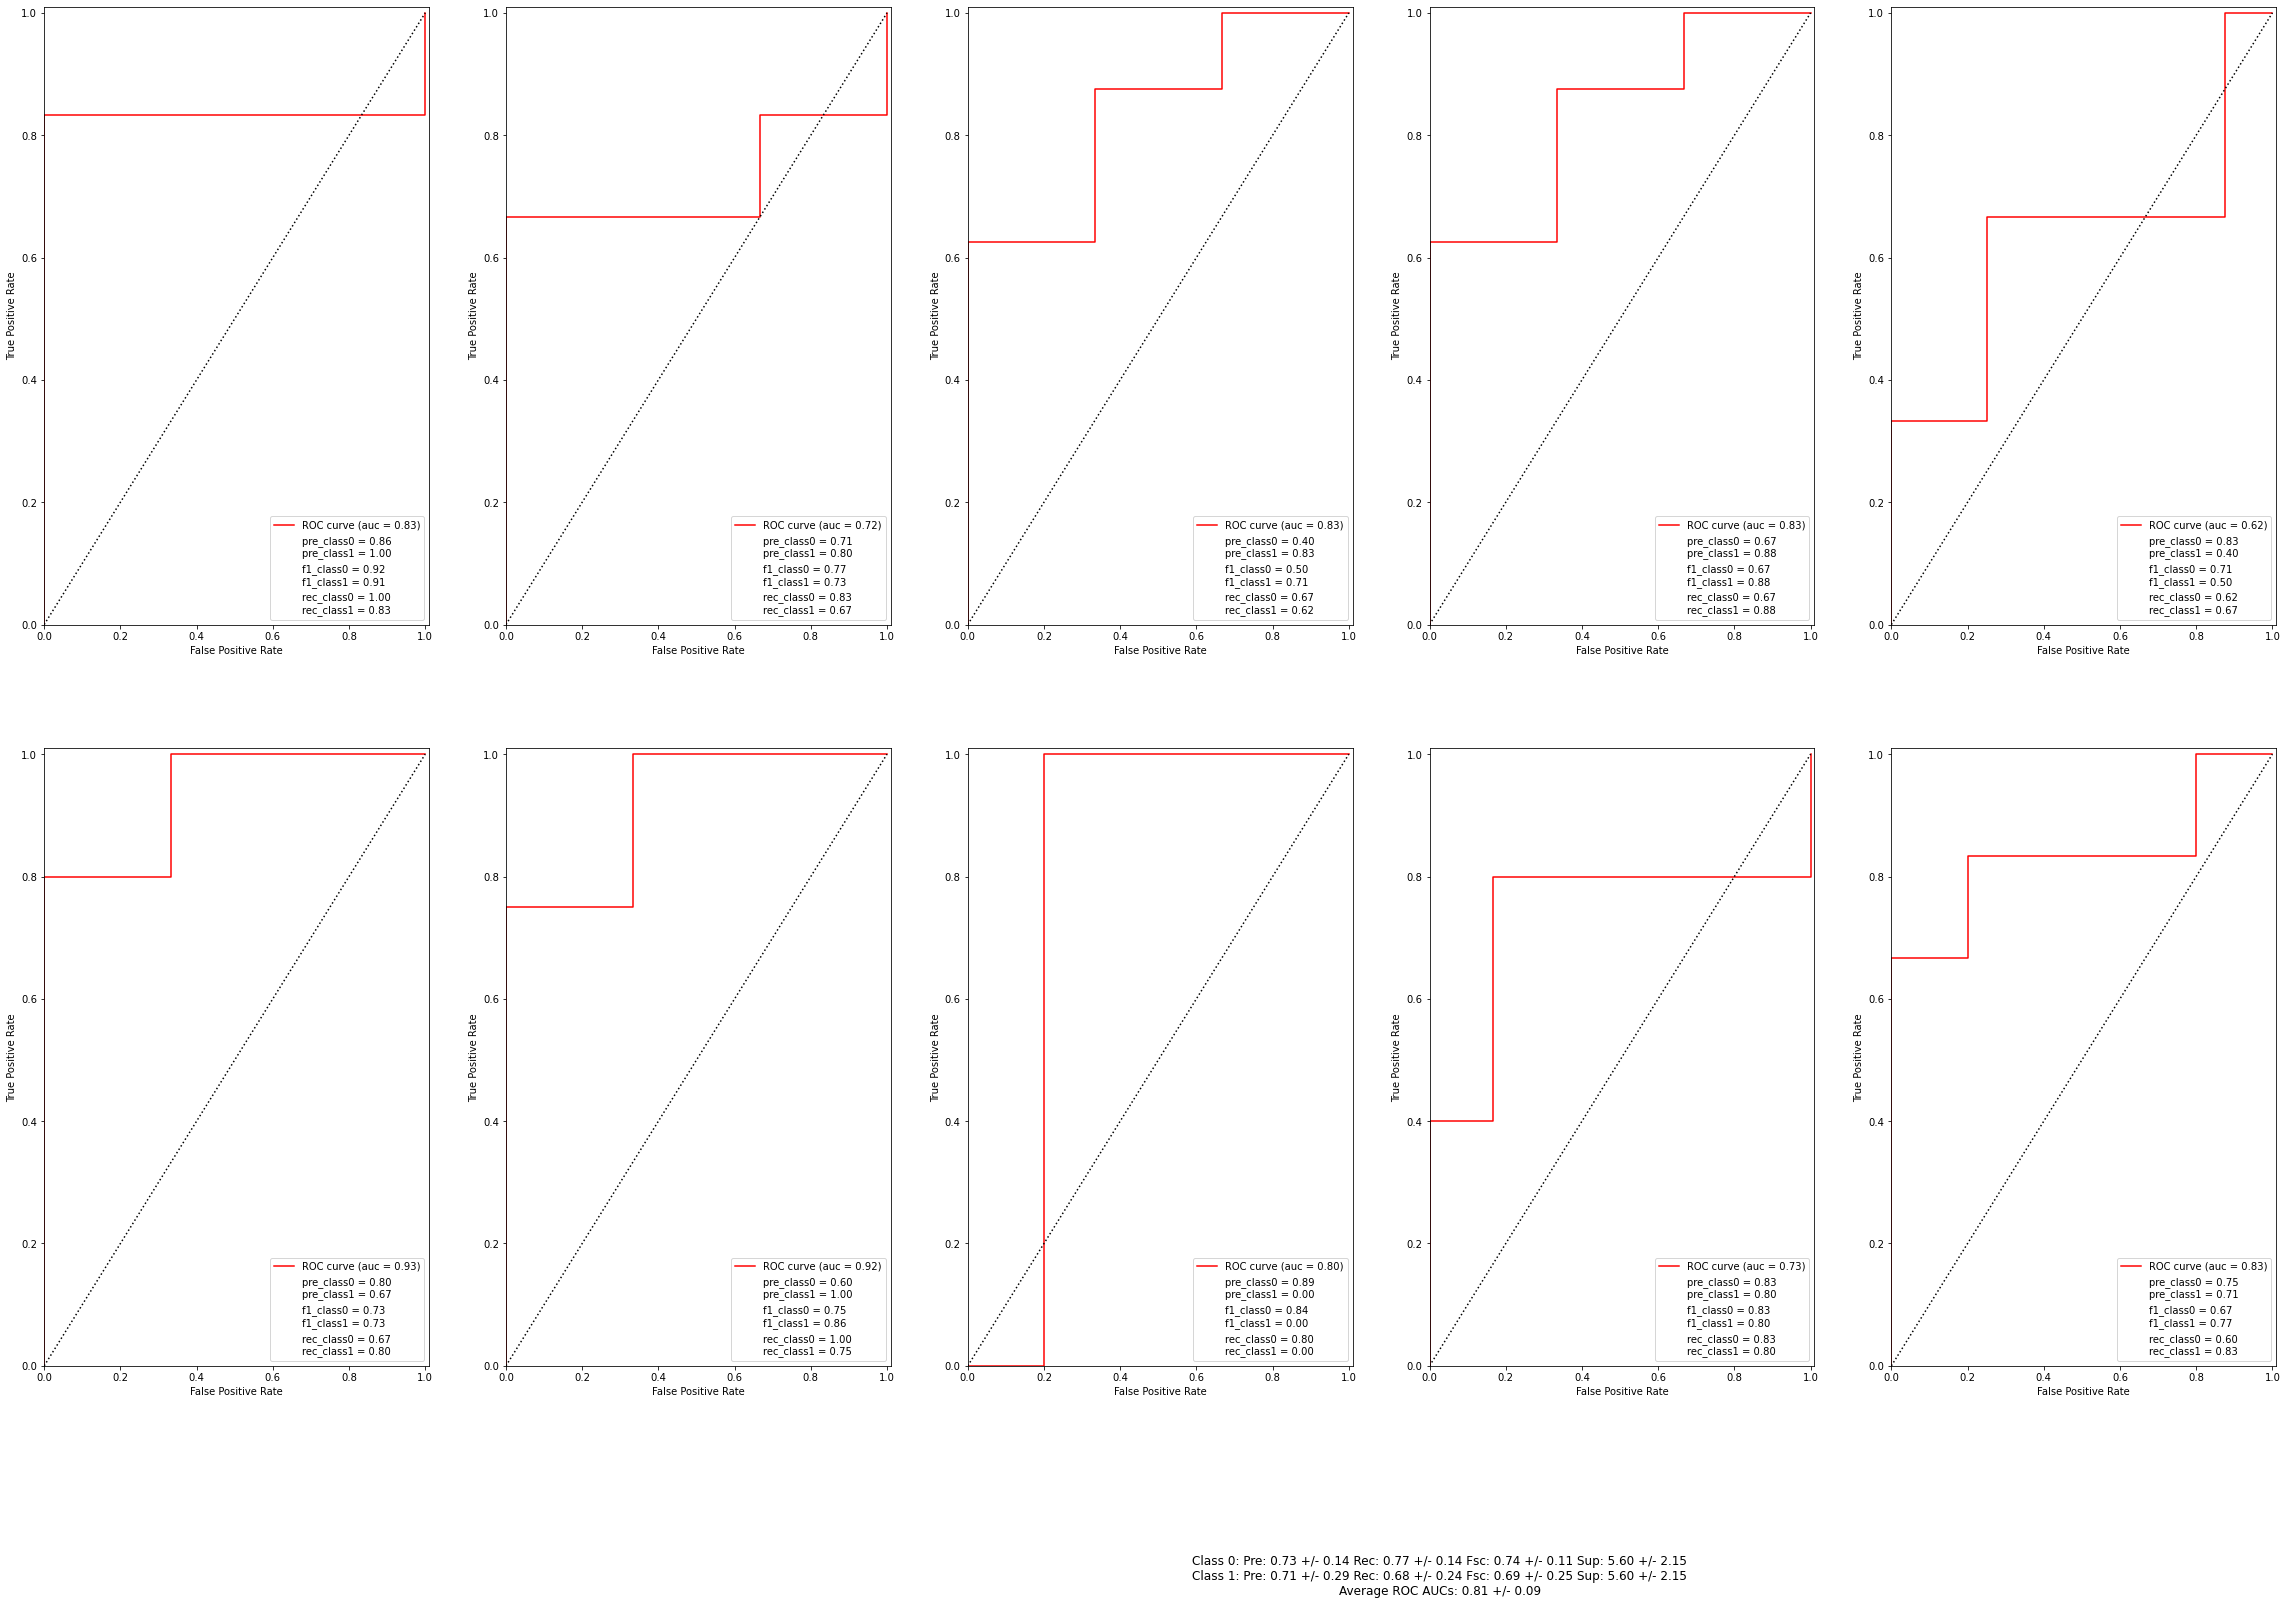


-----
Begin Decision Tree
-----

----- Decision_Tree: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
	Best parameters; {'max_depth': 7}
	0.6320 (+/-0.1664) for {'max_depth': 2}
	0.6870 (+/-0.2537

	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      1.00      0.67      0.94      0.82      0.69         8
          1       1.00      0.67      1.00      0.80      0.82      0.64         3

avg / total       0.92      0.91      0.76      0.90      0.82      0.68        11

	 Index | Predicted | Label
	------------------
	16   |   1   |   1
	30   |   0   |   0
	32   |   0   |   0
	35   |   1   |   1
	37   |   0   |   0
	58   |   0   |   0
	59   |   0   |   1
	60   |   0   |   0
	68   |   0   |   0
	94   |   0   |   0
	98   |   0   |   0
-----

----- Decision_Tree: Fold 5 -----
[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
	Best parameters; {'max_depth': 3}

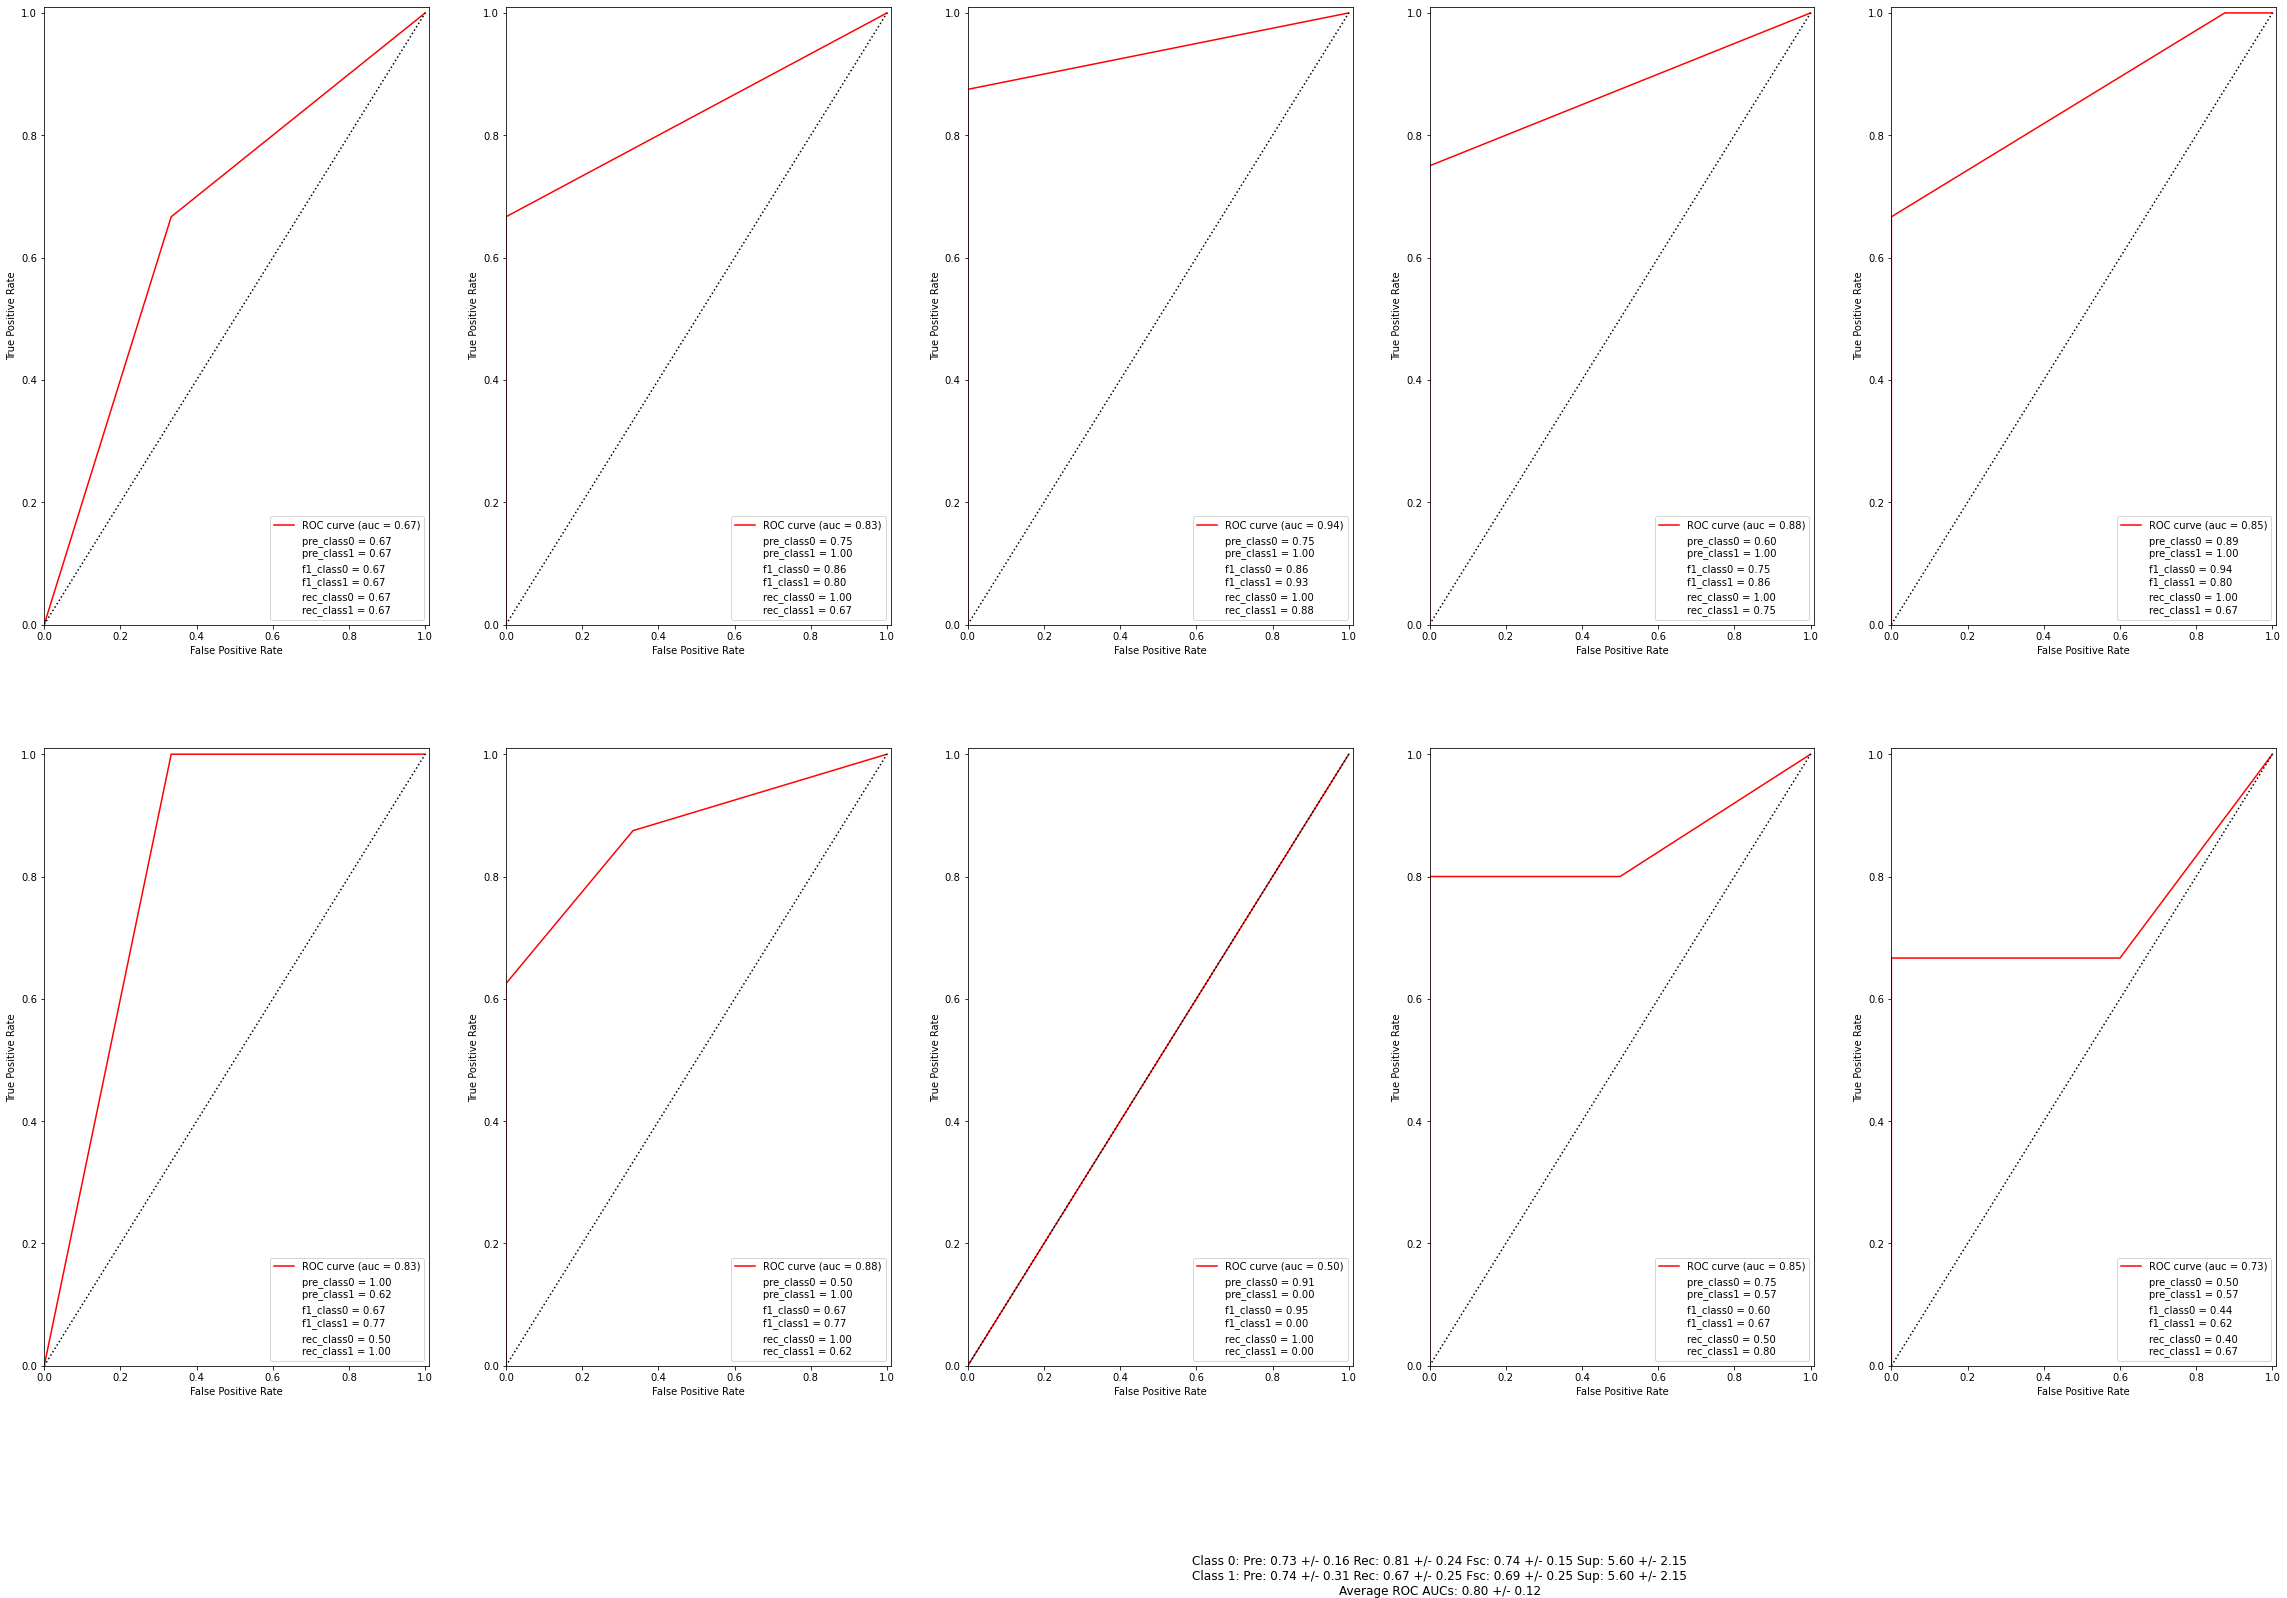


-----
Begin ExtraTreesClassifier
-----

----- ExtraTreesClassifier: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/m

	0.7400 (+/-0.2248) for {'max_depth': 10, 'n_estimators': 50}
	0.7780 (+/-0.1762) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under the curve: 0.8611111111111112
	Confusion matrix (ExtraTreesClassifier):
[[5 1]
 [3 3]]


	score (ExtraTreesClassifier): 0.6666666666666666
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.62      0.83      0.50      0.71      0.65      0.43         6
          1       0.75      0.50      0.83      0.60      0.65      0.40         6

avg / total       0.69      0.67      0.67      0.66      0.65      0.42        12

	 Index | Predicted | Label
	------------------
	5   |   0   |   1
	6   |   0   |   1
	18   |   1   |   1
	31   |   0   |   0
	33   |   0   |   0
	39   |   1   |   1
	56   |   1   |   0
	57   |   0   |   0
	75   |   0   |   1
	78   |   1   |   1
	103   |   0   |   0
	1

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
	Best parameters; {'max_depth': 7, 'n_estimators': 20}
	0.6814 (+/-0.1843) for {'max_depth': 2, 'n_estimators': 10}
	0.6720 (+/-0.2022) for {'max_depth': 2, 'n_estimators': 20}
	0.7473 (+/-0.1415) for {'max_depth': 2, 'n_estimators': 50}
	0.8039 (+/-0.1353) for {'max_depth': 2, 'n_estimators': 100}
	0.7365 (+/-0.1978) for {'max_depth': 3, 'n_estimators': 10}
	0.7286 (+/-0.1699) for {'max_depth': 3, 'n_estimators': 20}
	0.7579 (+/-0.1630) for {'max_depth': 3, 'n_estimators': 50}
	0.8170 (+/-0.1470) for {'max_depth': 3, 'n_estimators': 100}
	0.7890 (+/-0.1635) for {'max_depth': 4, 'n_estimators': 10}
	0.7774 (+/-0.1564) for {'max_depth': 4, 'n_estimators': 20}
	0.7731 (+/

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-r

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-r

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-r

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-r

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-r

----- ExtraTreesClassifier: Fold 9 -----
[15, 36, 49, 69, 70, 77, 82, 104, 106, 107, 110]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  37
  38  39  40  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  71  72  73  74  75  76
  78  79  80  81  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 105 108 109 111]
	Test indx: [ 15  36  49  69  70  77  82 104 106 107 110]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

	0.8251 (+/-0.1182) for {'max_depth': 2, 'n_estimators': 100}
	0.7318 (+/-0.1518) for {'max_depth': 3, 'n_estimators': 10}
	0.7413 (+/-0.1571) for {'max_depth': 3, 'n_estimators': 20}
	0.7253 (+/-0.1823) for {'max_depth': 3, 'n_estimators': 50}
	0.7707 (+/-0.1391) for {'max_depth': 3, 'n_estimators': 100}
	0.7503 (+/-0.1726) for {'max_depth': 4, 'n_estimators': 10}
	0.7424 (+/-0.1983) for {'max_depth': 4, 'n_estimators': 20}
	0.7575 (+/-0.1682) for {'max_depth': 4, 'n_estimators': 50}
	0.7784 (+/-0.1454) for {'max_depth': 4, 'n_estimators': 100}
	0.7397 (+/-0.1536) for {'max_depth': 5, 'n_estimators': 10}
	0.7360 (+/-0.1688) for {'max_depth': 5, 'n_estimators': 20}
	0.7093 (+/-0.1985) for {'max_depth': 5, 'n_estimators': 50}
	0.7378 (+/-0.1801) for {'max_depth': 5, 'n_estimators': 100}
	0.7615 (+/-0.1572) for {'max_depth': 7, 'n_estimators': 10}
	0.7806 (+/-0.1572) for {'max_depth': 7, 'n_estimators': 20}
	0.7527 (+/-0.1697) for {'max_depth': 7, 'n_estimators': 50}
	0.7482 (+/-0.1698) 

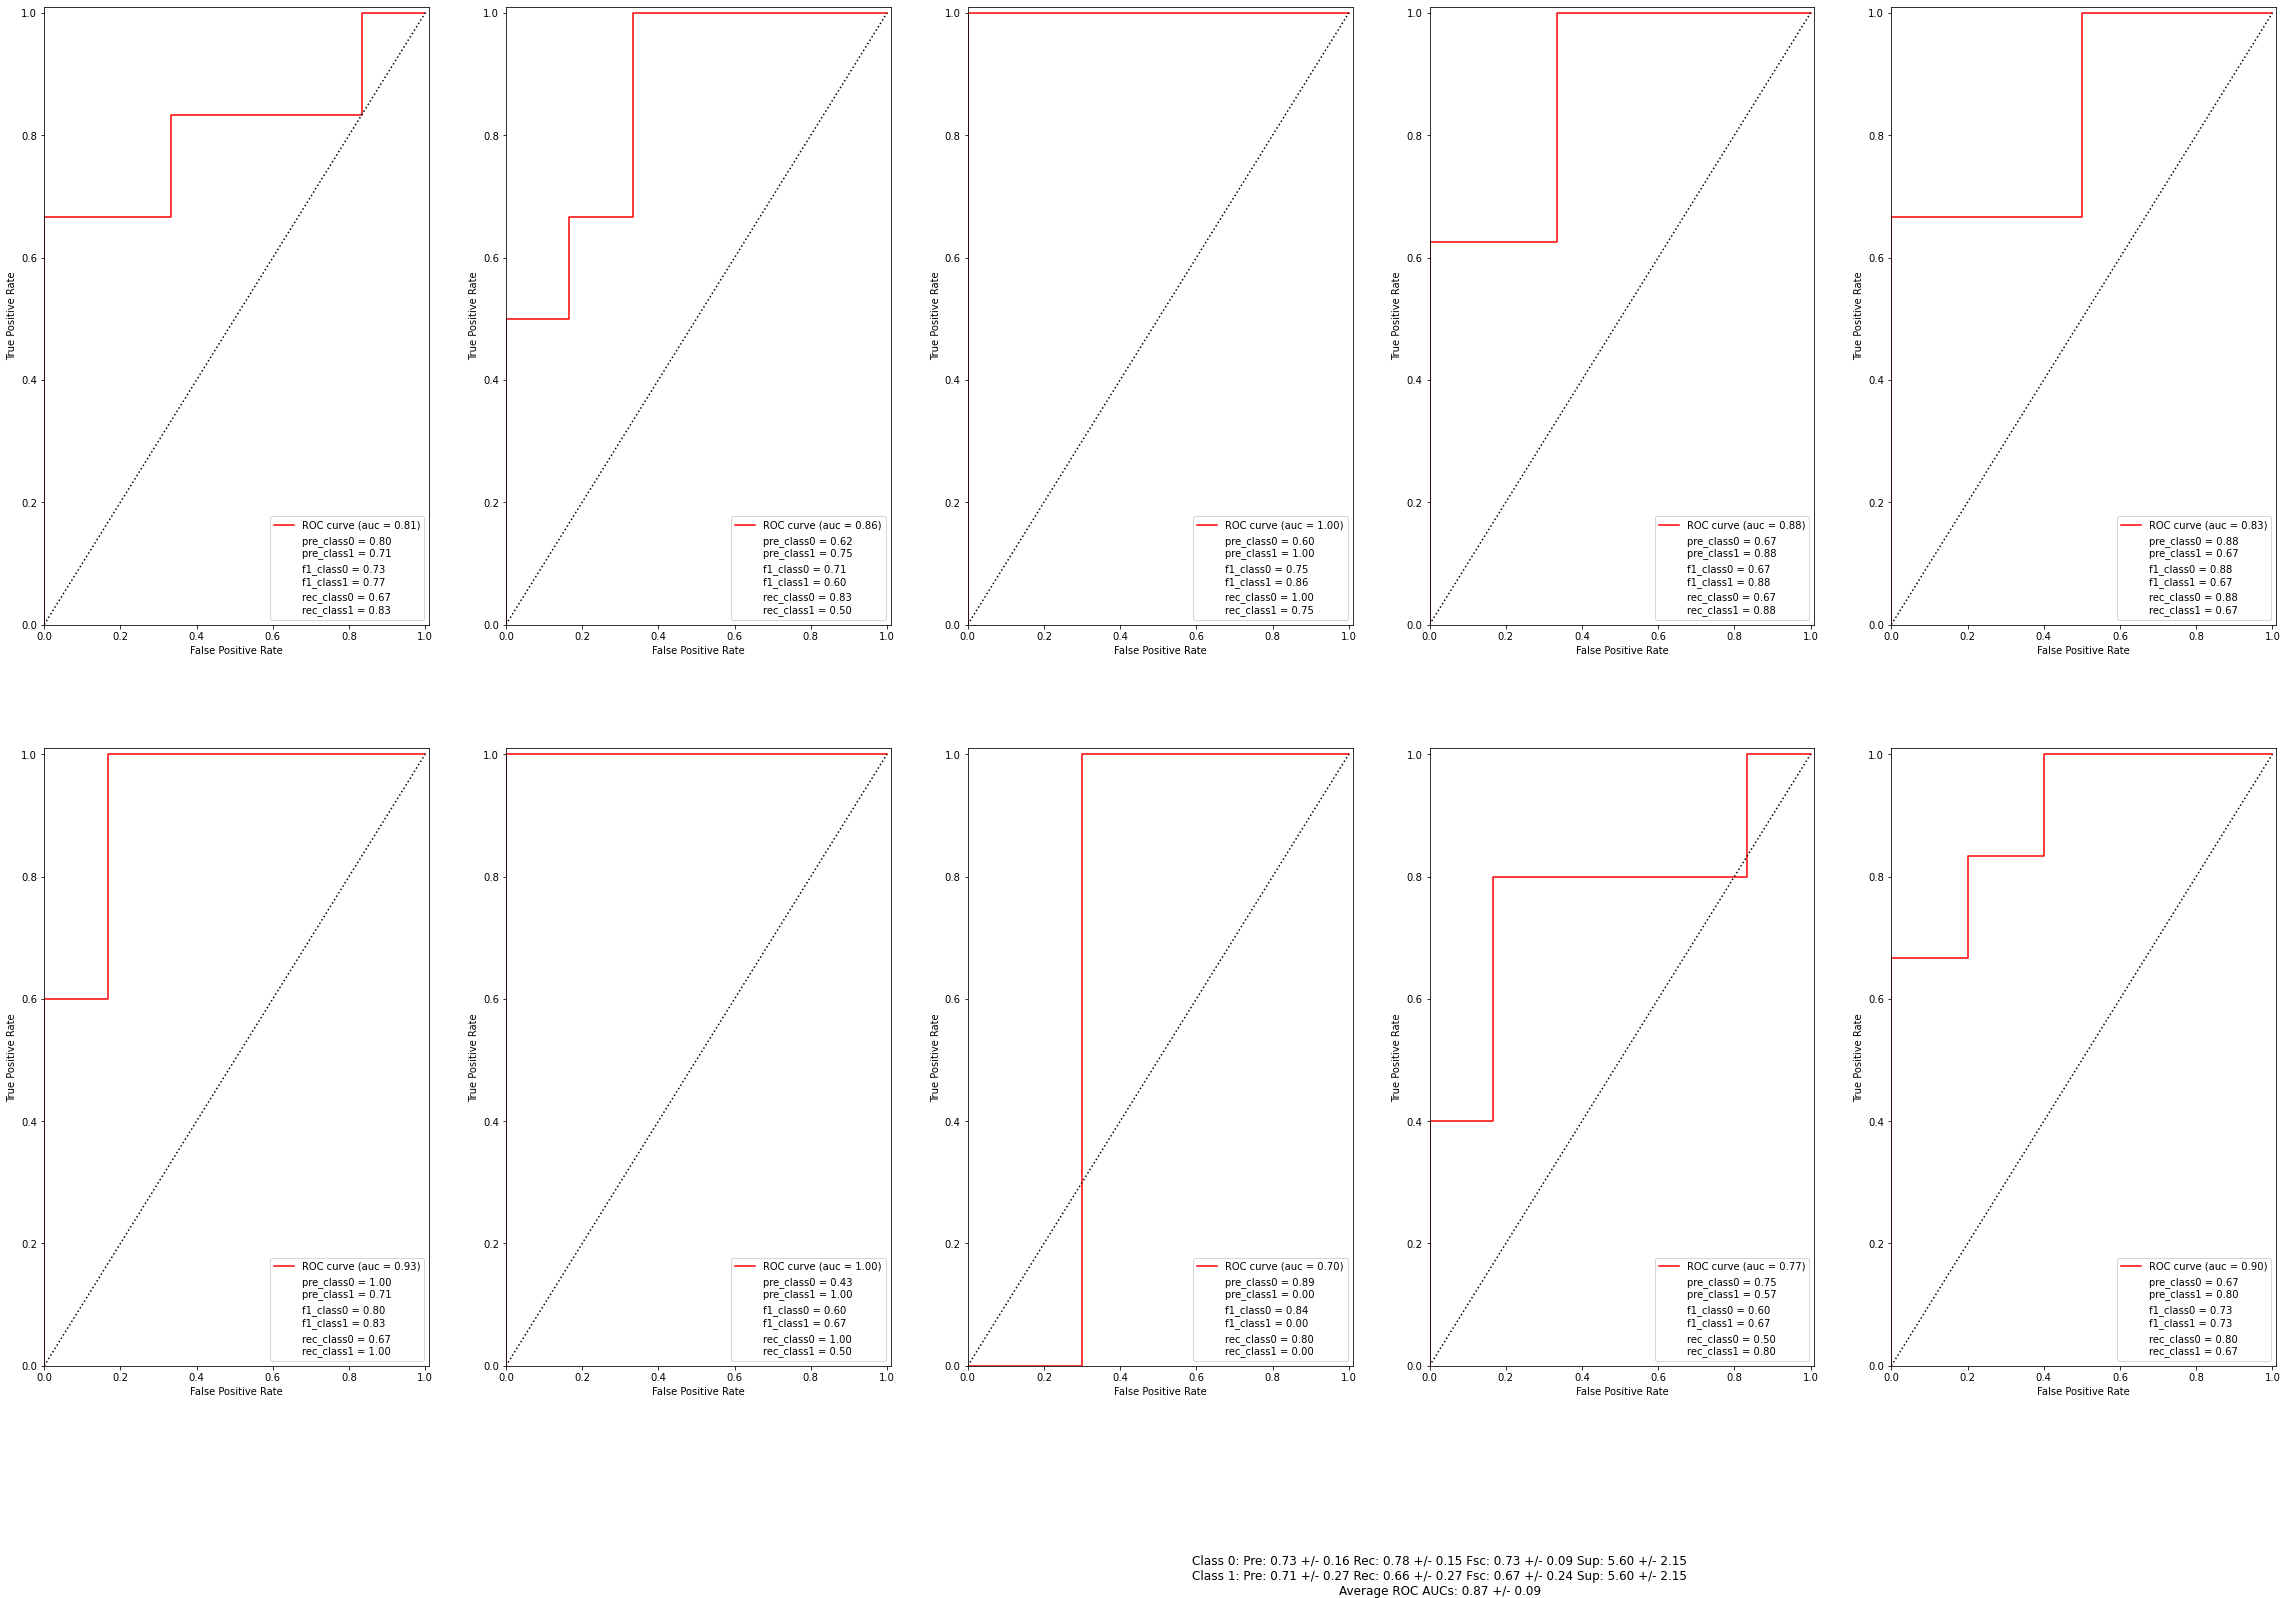


-----
Begin AdaBoost
-----

----- AdaBoost: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
	Best parameters; {'n_estimators': 20}
	0.6980 (+/-0.1930) for {'n_estimators': 10}
	0.7510 (+/-0.1301) for {'n_estimators': 20}
	0.7220 (+/-0.1246) for {'n_estimators': 50}
	0.7060 (+/-0.1790) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
	ROC analysis area under the curve: 0.7777777777777778
	Confusion matrix (AdaBoost):
[[3 3]
 [1 5]]


	score (AdaBoost): 0.6666666666666666
	Imbalence reports:
	Imba

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-r

	0.6389 (+/-0.1722) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
	ROC analysis area under the curve: 0.8833333333333333
	Confusion matrix (AdaBoost):
[[5 0]
 [1 5]]


	score (AdaBoost): 0.9090909090909091
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      1.00      0.83      0.91      0.91      0.85         5
          1       1.00      0.83      1.00      0.91      0.91      0.82         6

avg / total       0.92      0.91      0.92      0.91      0.91      0.83        11

	 Index | Predicted | Label
	------------------
	15   |   1   |   1
	36   |   0   |   0
	49   |   1   |   1
	69   |   0   |   1
	70   |   1   |   1
	77   |   1   |   1
	82   |   1   |   1
	104   |   0   |   0
	106   |   0   |   0
	107   |   0   |   0
	110   |   0   |   0
-----

All points have been used in a test case over all fold as they should have been
[[0.75333333 0.72630952]


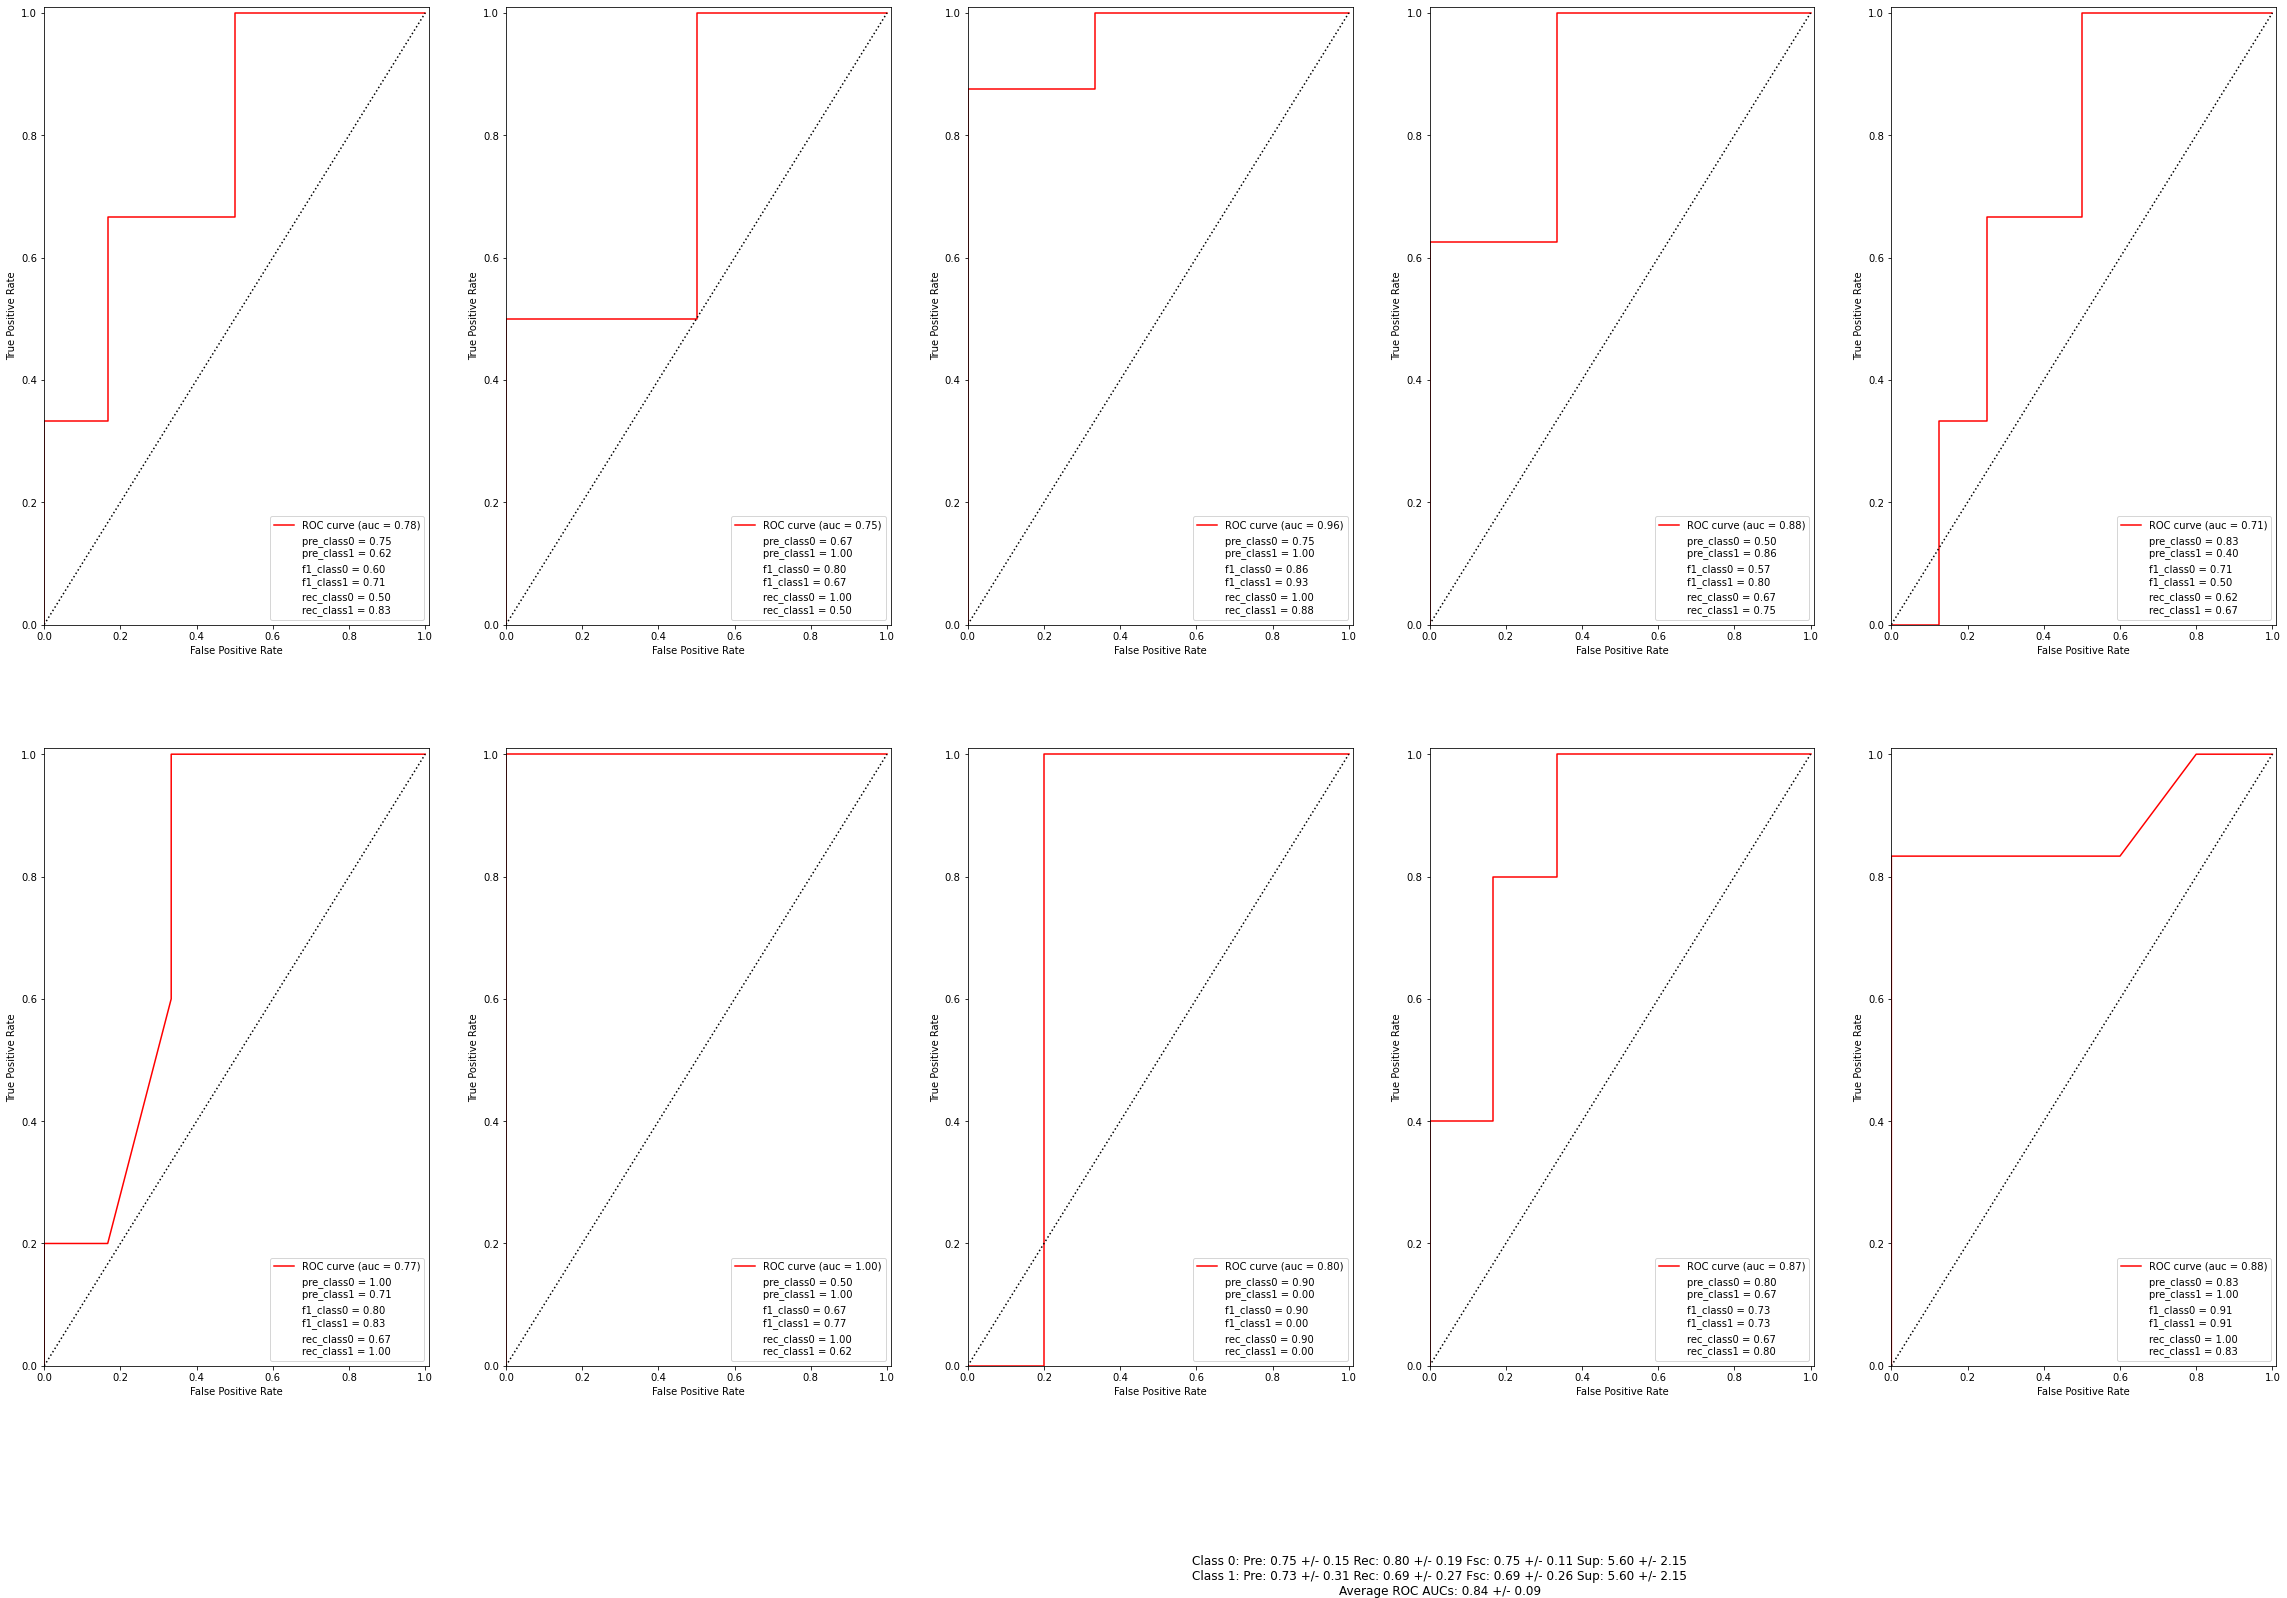


-----
Begin Logistic Regression
-----

----- Logistic_Regression: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
	Best parameters; {'C': 0.05, 'penalty': 'l2'}
	0.8520 (+/-0.0845) for {'C': 0.05, 'penalty': 'l2'}
	0.8460 (+/-0.0920) for {'C': 0.1, 'penalty': 'l2'}
	0.8140 (+/-0.1087) for {'C': 0.25, 'penalty': 'l2'}
	0.8140 (+/-0.1087) for {'C': 0.5, 'penalty': 'l2'}
	0.8020 (+/-0.1294) for {'C': 1.0, 'penalty': 'l2'}
	0.8100 (+/-0.1145) for {'C': 1.25, 'penalty': 'l2'}

	----- Predicting using: Logistic_Regress

	ROC analysis area under the curve: 0.875
	Confusion matrix (Logistic_Regression):
[[7 1]
 [1 2]]


	score (Logistic_Regression): 0.8181818181818182
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.88      0.67      0.88      0.76      0.60         8
          1       0.67      0.67      0.88      0.67      0.76      0.57         3

avg / total       0.82      0.82      0.72      0.82      0.76      0.59        11

	 Index | Predicted | Label
	------------------
	16   |   1   |   1
	30   |   0   |   0
	32   |   0   |   0
	35   |   1   |   1
	37   |   0   |   0
	58   |   0   |   0
	59   |   0   |   1
	60   |   0   |   0
	68   |   1   |   0
	94   |   0   |   0
	98   |   0   |   0
-----

----- Logistic_Regression: Fold 5 -----
[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  2

	2   |   0   |   0
	12   |   0   |   0
	20   |   1   |   0
	29   |   0   |   0
	34   |   0   |   0
	62   |   1   |   0
	67   |   1   |   1
	97   |   0   |   0
	100   |   0   |   0
	101   |   0   |   0
	111   |   0   |   0
-----

----- Logistic_Regression: Fold 8 -----
[1, 4, 21, 25, 43, 44, 55, 65, 87, 92, 93]
	Train indx [  0   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  22  23  24  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  45  46  47  48  49  50  51  52  53  54  56  57  58  59  60
  61  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  88  89  90  91  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 1  4 21 25 43 44 55 65 87 92 93]
	Best parameters; {'C': 0.05, 'penalty': 'l2'}
	0.8193 (+/-0.1592) for {'C': 0.05, 'penalty': 'l2'}
	0.8075 (+/-0.1773) for {'C': 0.1, 'penalty': 'l2'}
	0.8075 (+/-0.1773) for {'C': 0.25, 'penalty': 'l2'}
	0.8033 (+/-0

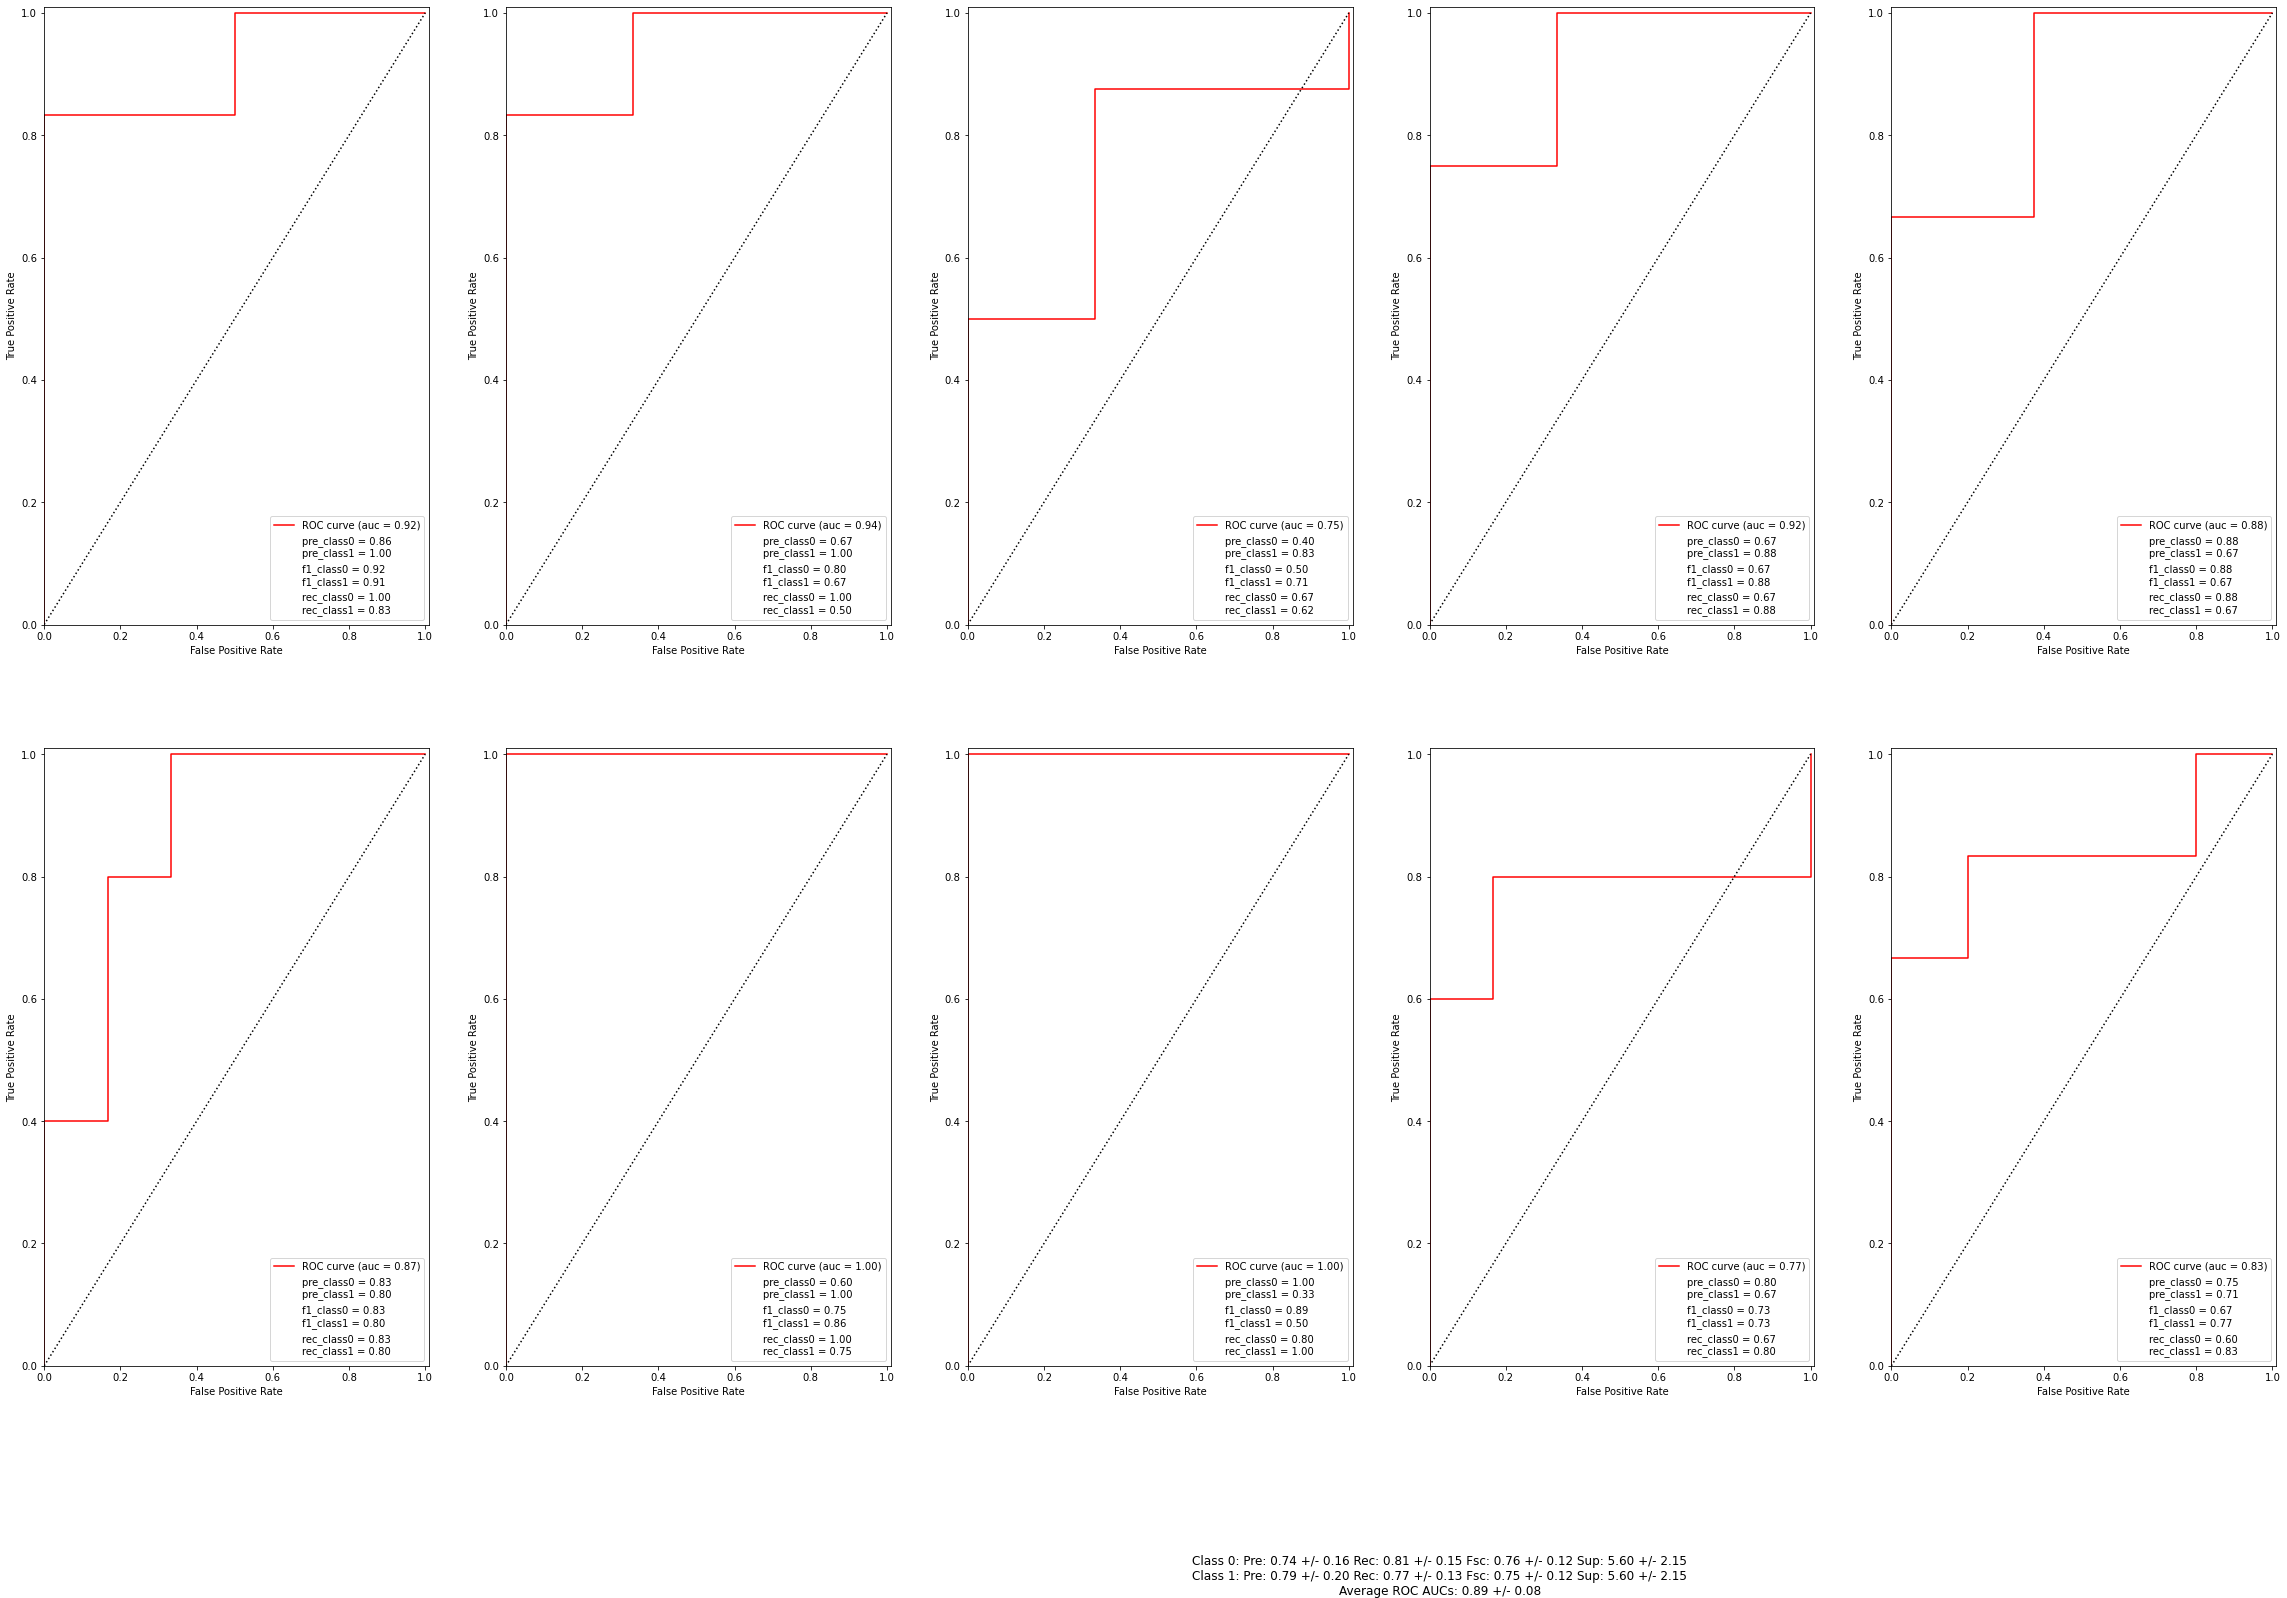

In [17]:
cwf.kfold_test_imbalenced_classifiers_with_optimization(features_smote_df, classes_smote_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=True, cv=5, n_repeats=10, smiles=None, names=None,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

In [18]:
directory_names = cwf.directory_names_from_classfier_names(kfold_clf_names)

In [19]:
directory_names

['Nearest_Neighbors',
 'Gaussian_Process',
 'Decision_Tree',
 'ExtraTreesClassifier',
 'AdaBoost',
 'Logistic_Regression']

## Analyses the output over all folds and predictions therefore for all moleucles
The next cell reads in the predictions from each fold (n_repeats max_folds should = n_repeats).


Nearest_Neighbors
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_nearest_neighbors_DFT.png
['ddg_nearest_neighbors_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 43, 'fp': 13, 'fn': 21, 'tp': 35}
[[43 13]
 [21 35]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Gaussian_Process
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_gaussian_process_DFT.png
['ddg_nearest_neighbors_DFT.png', 'ddg_gaussian_process_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 43, 'fp': 13, 'fn': 14, 'tp': 42}
[[43 13]
 [14 42]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Decision_Tree
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_decision_tree_DFT.png
['ddg_nearest_neighbors_DFT.png', 'ddg_gaussian_process_DFT.png', 'ddg_decision_tree_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 45, 'fp': 11, 'fn': 15, 'tp': 41}
[[45 11]
 [15 41]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_extratreesclassifier_DFT.png
['ddg_nearest_neighbors_DFT.png', 'ddg_gaussian_process_DFT.png', 'ddg_decision_tree_DFT.png', 'ddg_extratreesclassifier_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 43, 'fp': 13, 'fn': 16, 'tp': 40}
[[43 13]
 [16 40]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_adaboost_DFT.png
['ddg_nearest_neighbors_DFT.png', 'ddg_gaussian_process_DFT.png', 'ddg_decision_tree_DFT.png', 'ddg_extratreesclassifier_DFT.png', 'ddg_adaboost_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 44, 'fp': 12, 'fn': 14, 'tp': 42}
[[44 12]
 [14 42]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Logistic_Regression
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_logistic_regression_DFT.png
['ddg_nearest_neighbors_DFT.png', 'ddg_gaussian_process_DFT.png', 'ddg_decision_tree_DFT.png', 'ddg_extratreesclassifier_DFT.png', 'ddg_adaboost_DFT.png', 'ddg_logistic_regression_DFT.png']
Attempting to calculate confusion based metrics
{'tn': 46, 'fp': 10, 'fn': 14, 'tp': 42}
[[46 10]
 [14 42]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearest neighbors      &  0.696429 &     0.625000 &     0.767857 &  0.396928 &   0.729167 &  0.692756 \\
gaussian process       &  0.758929 &     0.750000 &     0.767857 &  0.517940 &   0.763636 &  0.758876 \\
decision tree          &  0.767857 &     0.732143 &     0.803571 &  0.537086 &   0.788462 &  0.767026 \\
extra trees classifier &  0.741071 &     0.714286 &     0.767857 &  0.482836 &   0.754717 &  0.740587 \\
adaboost               &  0.767857 &     0.750000 &     0.785714 &  0.536056 &   0.777778 &  0.767649 \\
logistic regression    &  0.785714 &     0.750000 &     0.821429 &  0.572892 &   0.807692 &  0.784902 \\
\bottomrule
\end{tabular}



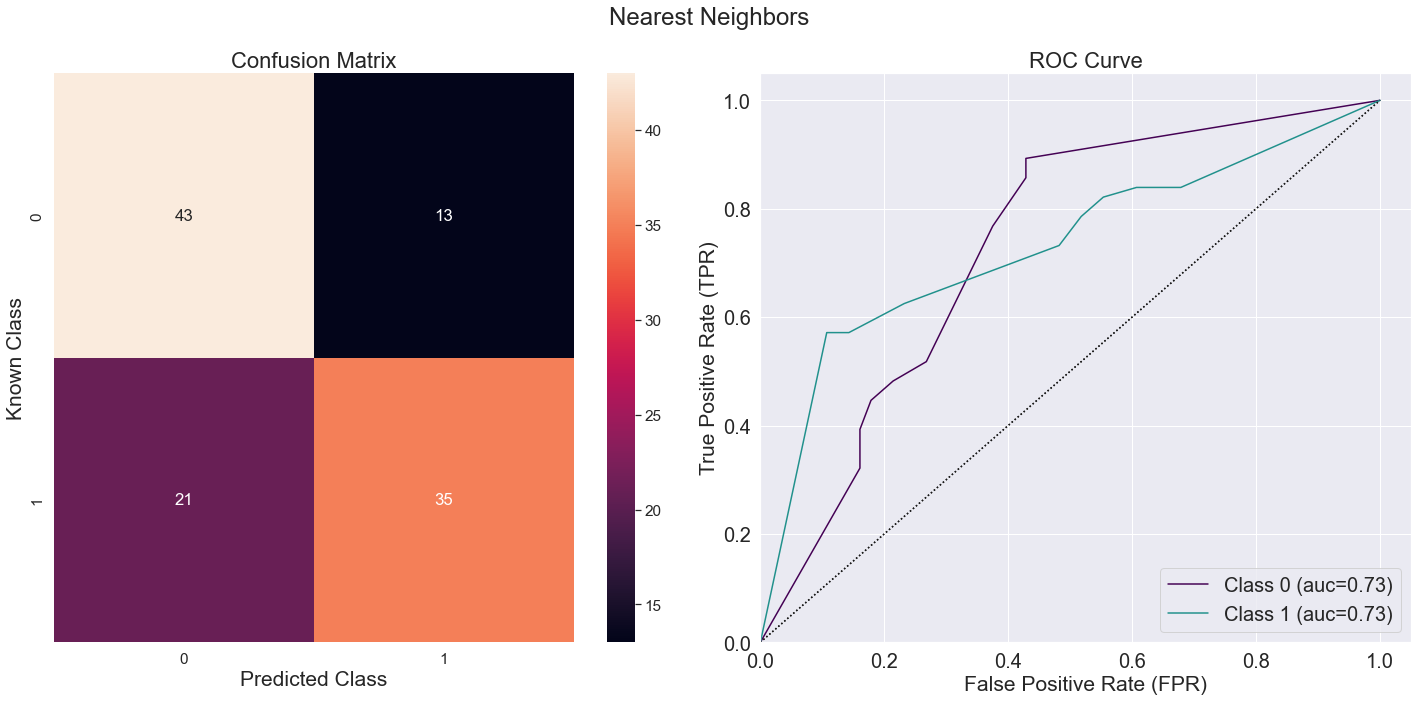

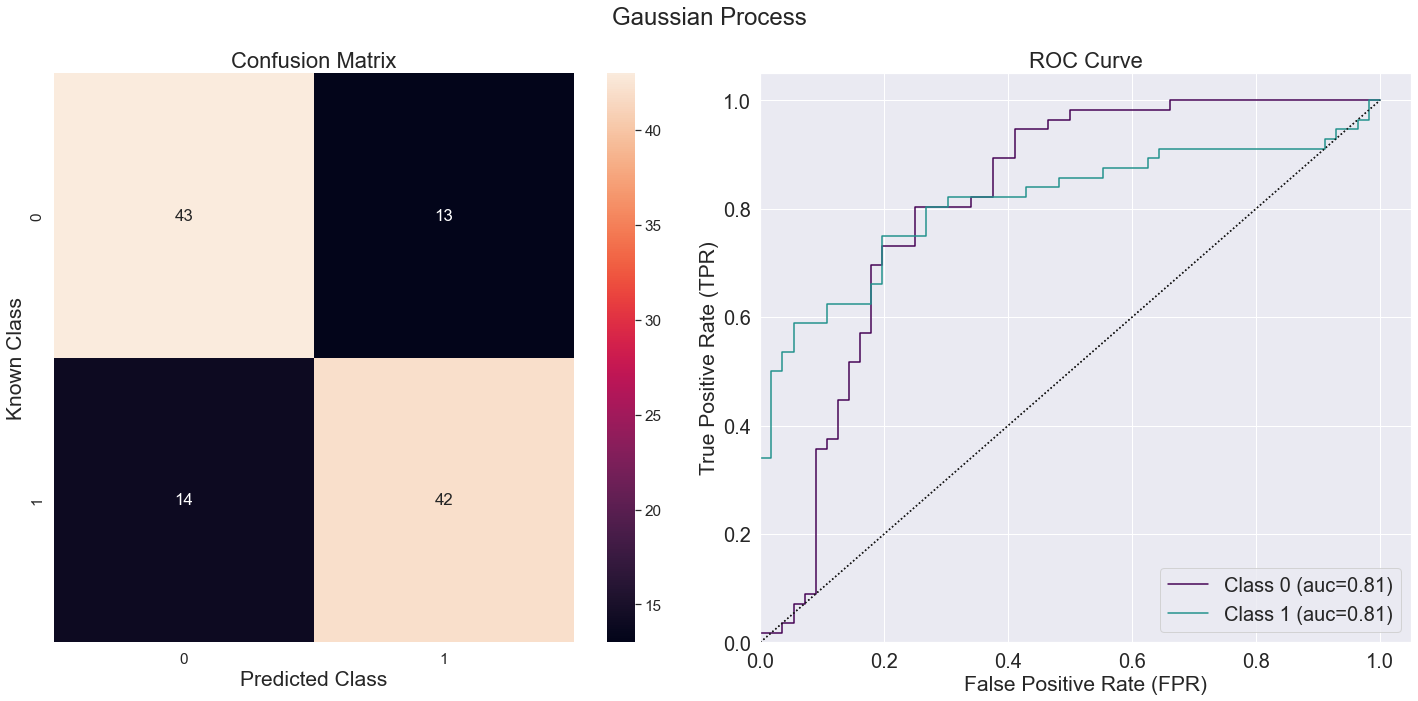

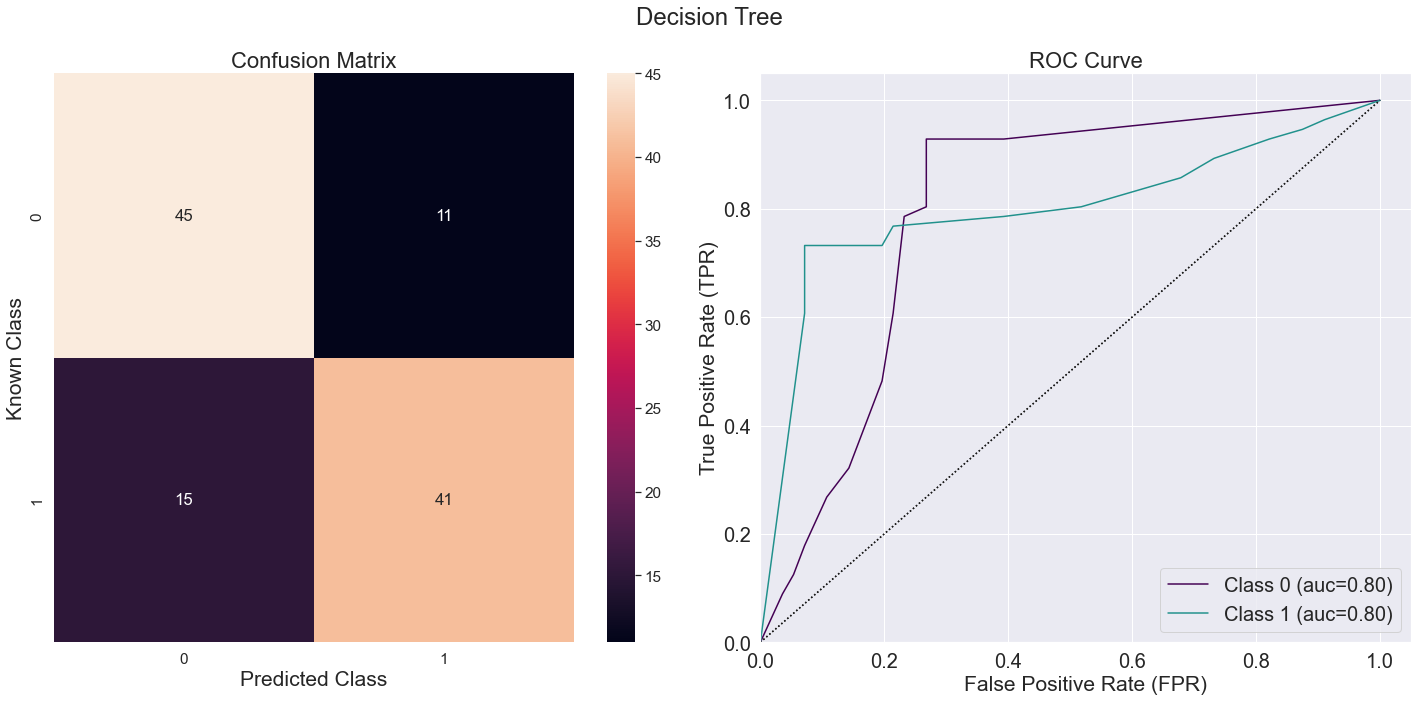

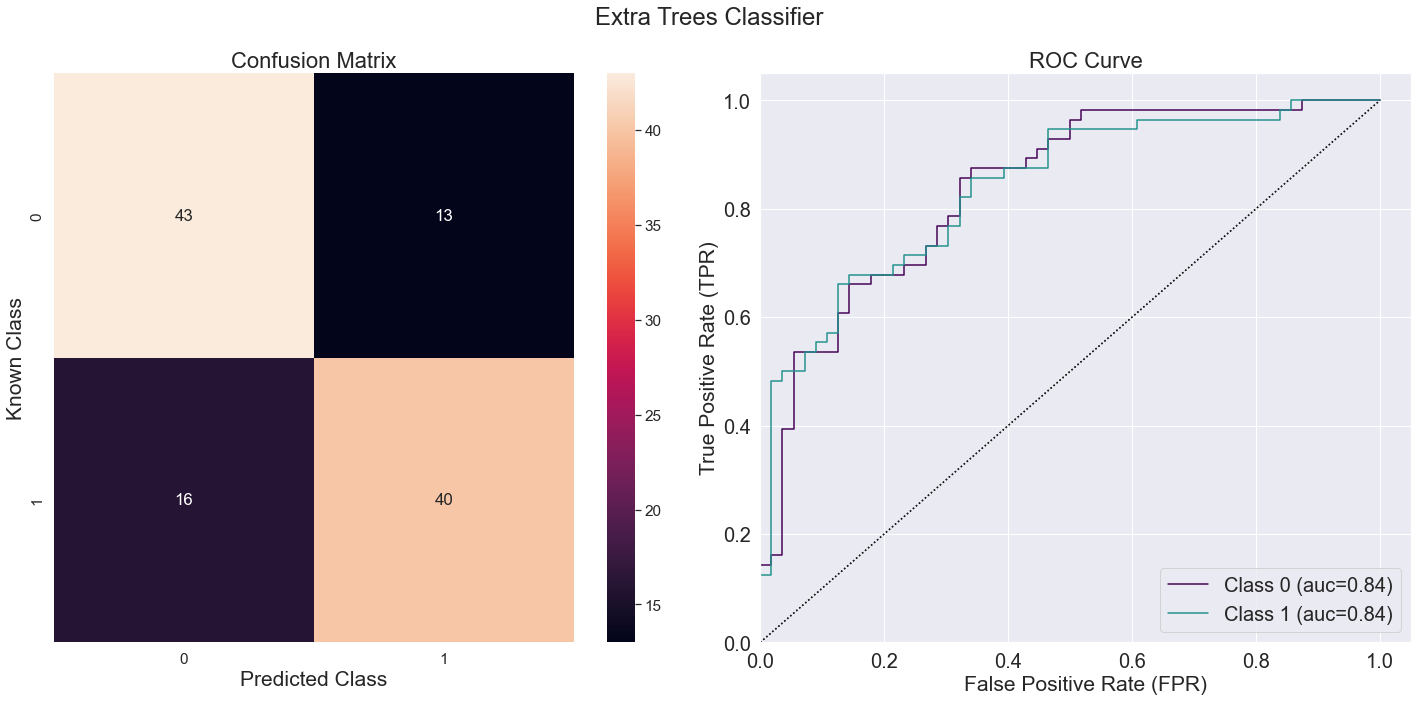

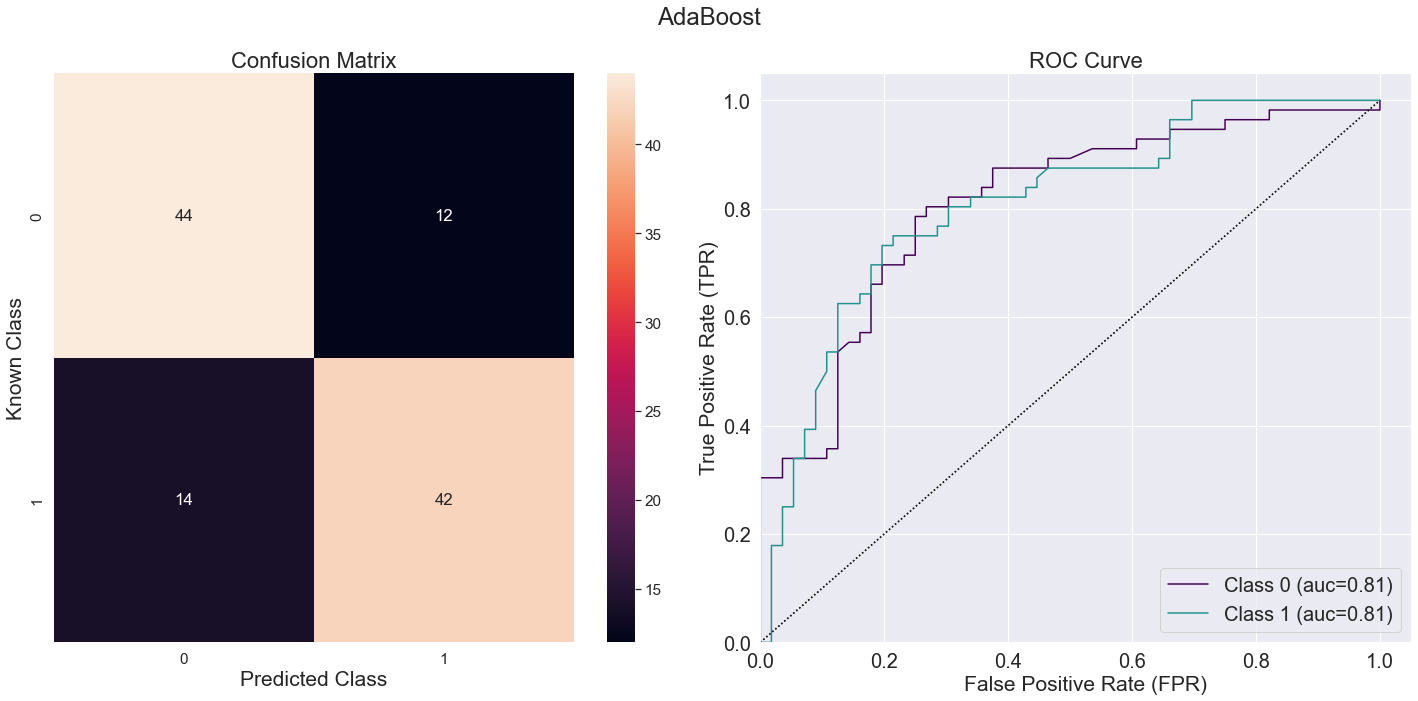

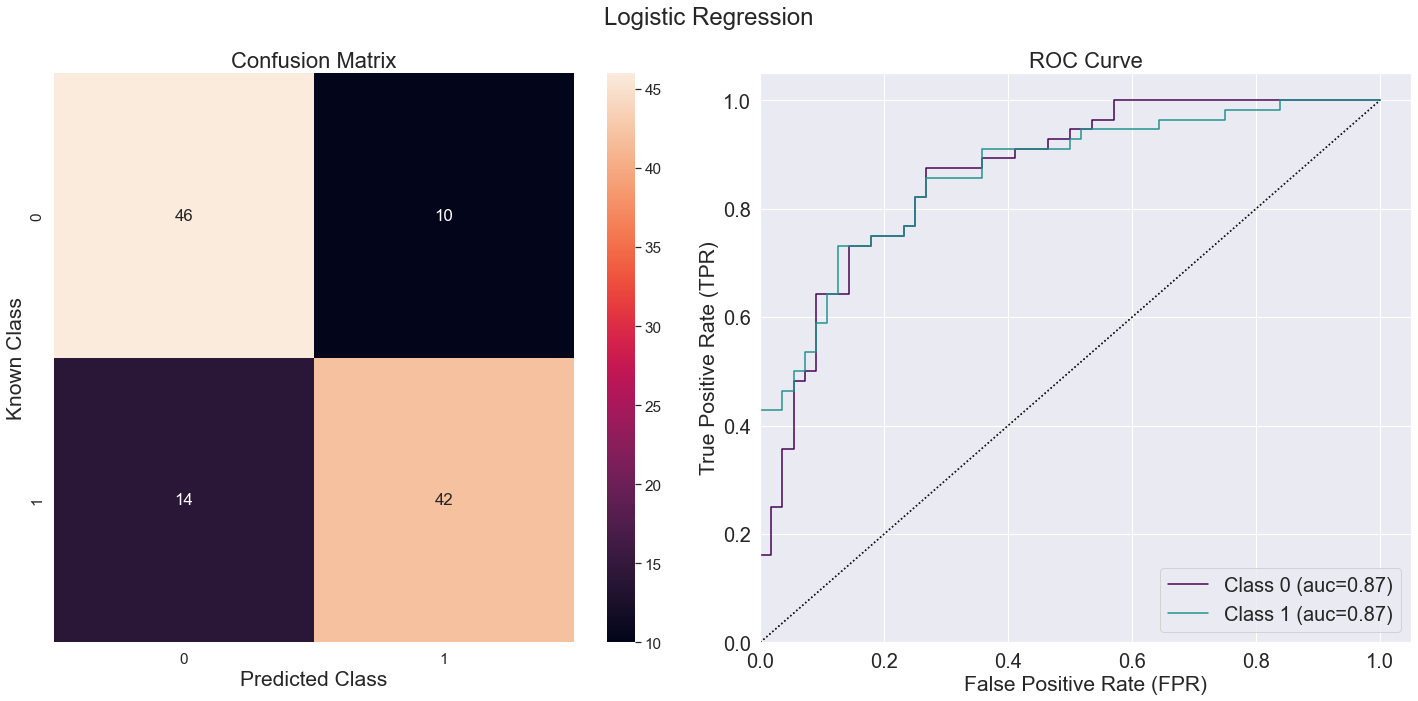

In [21]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=10)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_DFT.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_DFT.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [22]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600


# Now first we split 90%-10% (train-test)

In [52]:
data = pd.read_csv("dftset2/set2ReactionMatrix.csv", header = None)

We know which data points we are using for test set, for consistency reasons. 
These are: 

In [53]:
test_reactions = [44, 33, 69, 0, 6, 35, 56, 67, 58]

we romove from the data the test reactions

In [54]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

and we generate the test dataframe

In [55]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [56]:
ddg = pd.read_csv("DDGset2.csv", header = None)

In [57]:
ddg_train = ddg.drop(labels =test_reactions, axis=0,inplace = False)

In [58]:
ddg_test = ddg.iloc[test_reactions]

# Classify the training set

In [59]:
classes_train=[]
for index, value in ddg_train[0].items():
    if value < 4:
        classes_train.append(0)
    else:
        classes_train.append(1)

In [60]:
classes_train
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])
features_and_classes_df_train = train_data.copy()
features_and_classes_df_train["classes"] = classes_train
feature_types = "no_catagorical"

In [61]:
class_targets_df_train["classes"].values

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Synthetic Sampling for the training

In [62]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_catagorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=catagorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "catagorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [63]:
log.info("Feature decriptions:\n{}".format(train_data.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Feature decriptions:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]
Classes/Targets descriptions:
['classes']


In [64]:
features_smote_train, classes_smote_train = sm.fit_resample(train_data.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(train_data.index)
log.info("SMOTE has added {} sythetic features to balence the classes".format(n_sythetic_points))

SMOTE has added 21 sythetic features to balence the classes


In [65]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[-4.7        -0.976       0.0886     ...  3.34        1.88
   2.02      ]
 [-5.79       -1.35        0.0862     ...  3.34        1.88
   2.02      ]
 [-5.12       -1.56        0.0952     ...  3.34        1.88
   2.02      ]
 ...
 [-4.72       -1.16        0.0943     ...  3.77748855  2.20082493
   2.43925986]
 [-4.72       -1.16        0.0943     ...  0.37366325  0.15056431
   0.58247506]
 [-4.72       -1.16        0.0943     ...  2.08355014  0.52088753
   0.96517396]]
(102, 54)
Resampled y:
[0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(102,)


In [66]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=train_data.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,classes
0,-4.70000,-0.976000,0.088600,-0.048800,-0.075000,3.700000,4.28000,2.270000,8.850000,4.230000,...,6.850000,2.930000,9.600000,6.800000,1.700000,3.150000,3.340000,1.880000,2.020000,0
1,-5.79000,-1.350000,0.086200,-0.052000,-0.064700,3.170000,4.32000,3.050000,5.970000,4.190000,...,6.850000,2.930000,9.600000,6.800000,1.700000,3.150000,3.340000,1.880000,2.020000,0
2,-5.12000,-1.560000,0.095200,-0.049500,-0.056700,4.150000,4.29000,1.930000,7.230000,5.380000,...,6.850000,2.930000,9.600000,6.800000,1.700000,3.150000,3.340000,1.880000,2.020000,0
3,-5.06000,-0.981000,0.086300,-0.049200,-0.029800,6.040000,4.27000,3.120000,5.950000,4.180000,...,6.850000,2.930000,9.600000,6.800000,1.700000,3.150000,3.340000,1.880000,2.020000,0
4,-5.05000,-1.150000,0.121000,-0.051700,-0.029300,6.260000,4.70000,3.010000,6.720000,4.190000,...,6.850000,2.930000,9.600000,6.800000,1.700000,3.150000,3.340000,1.880000,2.020000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,-5.10095,-1.376167,0.092374,-0.049405,-0.048159,4.750077,4.28365,2.307826,6.823599,4.998999,...,6.850000,2.930000,9.600000,6.800000,1.700000,3.150000,3.340000,1.880000,2.020000,0
98,-4.72000,-1.160000,0.094300,-0.047800,-0.008940,3.390000,4.31000,2.090000,7.380000,5.540000,...,7.230011,3.282503,10.158324,3.860951,1.880000,2.020000,6.800000,2.306569,7.495130,0
99,-4.72000,-1.160000,0.094300,-0.047800,-0.008940,3.390000,4.31000,2.090000,7.380000,5.540000,...,8.333879,2.981247,9.880103,4.685472,1.444798,2.001593,3.777489,2.200825,2.439260,0
100,-4.72000,-1.160000,0.094300,-0.047800,-0.008940,3.390000,4.31000,2.090000,7.380000,5.540000,...,0.394544,0.179688,0.560495,0.183535,0.103307,0.111000,0.373663,0.150564,0.582475,0


Now for the test set 

In [67]:
classes_test=[]
for index, value in ddg_test[0].items():
    if value < 4:
        classes_test.append(0)
    else:
        classes_test.append(1)

# Define Xtrain, Xtest, Ytrain, Ytest

In [68]:
Xtrain = features_smote_df_train
Xtest = test_data
Ytrain = classes_smote_df_train
Ytest = classes_test

# Time for ML

In [69]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "Decision Tree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [70]:
def minmaxscale(df):
    """
    scale a pandas dataframe using min max scaling
    :param df: pandas dataframe - data frame to be returned scaled
    """
    
    df_tmp = df.copy()
    normalized_df = (df_tmp-df_tmp.min())/(df_tmp.max()-df_tmp.min())
    return normalized_df

In [71]:
def grid_search_classifier_parameters(clf, Xtrain, ytrain, clf_options, clf_names, iteration, no_train_output, cv=5, name=None, scoring=("roc_auc", "precision", "recall")):
    """
    Grid search calssifer hyperparams and find the best report metrics if requested
    """
    log = logging.getLogger(__name__)
    
    # Grid search model optimizer
    parameters = clf_options[clf_names[iteration]]
    log.debug("\tname: {} parameters: {}".format(name, parameters))
    
    optparam_search = GridSearchCV(clf, parameters, cv=cv, error_score=np.nan, scoring=scoring, refit=scoring[0], return_train_score=True)
    log.debug("\tCV xtrain: {}".format(Xtrain))
    
    optparam_search.fit(Xtrain, ytrain.values.ravel())
    opt_parameters = optparam_search.best_params_
    
    if no_train_output is False:
        reported_metrics = pd.DataFrame(data=optparam_search.cv_results_)
        reported_metrics.to_csv("{}/{}_grid_search_metrics.csv".format(name,name))
        log.info("\tBest parameters; {}".format(opt_parameters))
        for mean, std, params in zip(optparam_search.cv_results_["mean_test_{}".format(scoring[0])], 
                                     optparam_search.cv_results_["std_test_{}".format(scoring[0])], 
                                     optparam_search.cv_results_['params']):
            log.info("\t{:.4f} (+/-{:.4f}) for {}".format(mean, std, params))
    else:
        pass
    
    return opt_parameters

In [72]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support
def kfold_test_imbalenced_classifiers_with_optimization(df, test_df, classes, testclasses, classifiers, clf_options, scale=True, cv=5, n_repeats=20, clf_names=None, 
                                                        class_labels=(0,1), no_train_output=False, smiles=None, names=None,
                                                        random_seed=107901, overwrite=False):
    """
    function to run classification test over classifiers using imbalenced resampling
    inspired from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    :param df: dataframe - data frame of features and identifers (smiles and/or names)
    :param classes: iterable - list of classes/labels
    :param classifiers: list - list of classifier methods
    :param plot: true/false - plot the results or not
    """
    
    log = logging.getLogger(__name__)
    
    log.info("Features: {}".format(df.columns))
    
    log_df = pd.DataFrame()
    labelpredictions = pd.DataFrame()
    
    predicted,list_opt_param=[],[]
    list_report, list_roc_auc, list_opt_param, list_score, list_c_matrix=[],[],[],[],[]
    iteration = 0
    pd.set_option('display.max_columns', 20)
    data = df.copy()
    data.reset_index(inplace=True)
       
    if clf_names is None:
        clf_names = [i for i in range(0, len(classifiers))]
    
    if scale is True:
        data = minmaxscale(data)
        log.info("Scaled data:\n{}".format(data))
    else:
        log.info("Using unscaled features")
    
    for name, classf in zip(clf_names, classifiers):
        log.info("\n-----\nBegin {}\n-----\n".format(name))
        
        kf_iteration = 0
        if not n_repeats % 2:
            figure = plt.figure(figsize=(2 * 20.0, 5.0 * int(n_repeats/2.0)))
            plt_rows = int(n_repeats/2.0)
        else:
            figure = plt.figure(figsize=(2 * 20.0, 5.0 * int(n_repeats/2.0)+1))
            plt_rows = nt(n_repeats/2.0)+1
        scores = []
        confusion_matrices = []
        roc_aucs = []
        score_list = []
        tmp = []
        name = "{}".format("_".join(name.split()))
        
        # Make directory for each classifier
        if not os.path.isdir(name):
            os.makedirs(name, exist_ok = True)
        elif overwrite is False and os.path.isdir(name) is True:
            log.warning("Directory already exists and overwrite is False will stop before overwriting.".format(name))
            return None
        else:
            log.info("Directory {} already exists will be overwritten".format(name))
        
            # Train
        Xtrain = df
        log.debug("Train X\n{}".format(Xtrain))
        df.to_csv('Xtrain.csv')
        ytrain = classes
        log.debug("Train Y\n{}".format(ytrain))
            
            # Test
        Xtest = test_df
        log.debug("Test X\n{}".format(Xtest))
        test_df.to_csv('Xtest.csv')
        ytest = testclasses
        log.debug("Test Y\n{}".format(ytest))
        
            # Grid search model optimizer
        opt_param = grid_search_classifier_parameters(classf, Xtrain, ytrain, clf_options, clf_names, iteration, no_train_output, cv=cv, name=name)
                 
        list_opt_param.append(opt_param)
            
            # Fit final model using optimized parameters
        clf = classf
        clf.set_params(**opt_param)
        log.info("\n\t----- Predicting using: {} -----".format(name))
        log.debug("\tXtrain: {}\n\tXtest: {}\n\tytrain: {}\n\tytest: {}".format(Xtrain, Xtest, ytrain, ytest))
        clf.fit(Xtrain, ytrain)
            
            # Evaluate the model
            ## evaluate the model on multiple metric score as list for averaging
        predicted_clf = clf.predict(Xtest)
        sc = precision_recall_fscore_support(ytest, predicted_clf, average=None)
        sc_df = pd.DataFrame(data=np.array(sc).T, columns=["precision", "recall", "f1score", "support"])
        sc_df.to_csv(os.path.join(name, "fold_{}_score.csv".format(kf_iteration)))
        score_list.append(sc)
            
            ## evaluate the principle score metric only (incase different to those above although this is unlikely)
        clf_score = clf.score(Xtest, ytest)
        scores.append(clf_score)
            
            ## Get the confusion matrices 
        c_matrix = confusion_matrix(ytest, predicted_clf, labels=class_labels)
        confusion_matrices.append(c_matrix)
            
            ## Calculate the roc area under the curve
        probs = clf.predict_proba(Xtest)
        fpr, tpr, thresholds = roc_curve(ytest, probs[:,1], pos_label=1)
        roc_auc = auc(fpr, tpr)
            
        list_roc_auc.append(roc_auc)
            
        roc_aucs.append(roc_auc)
        log.info("\tROC analysis area under the curve: {}".format(roc_auc))
            
            # output metrics for consideration
        log.info("\tConfusion matrix ({}):\n{}\n".format(name, c_matrix))
            
        list_c_matrix.append(c_matrix)
        log.info("\n\tscore ({}): {}".format(name, clf_score))   

        list_score.append(clf_score)
        
        log.info("\tImbalence reports:")
        log.info("\tImbalence classification report:\n{}".format(classification_report_imbalanced(ytest, predicted_clf)))
        output_dict = classification_report_imbalanced(ytest, predicted_clf, output_dict=True)
            
            ## Plot the roc curves
        ax = plt.subplot(2, plt_rows, kf_iteration+1)
        ax.plot(fpr, tpr, color="red",
                     lw=1.5, label="ROC curve (auc = {:.2f})".format(roc_auc))
            
                # ugliest legend i ve made in my life - maybe one under the other?
            
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "pre_class0 = {:.2f}\n".format(output_dict[0]['pre'])+"pre_class1 = {:.2f}".format(output_dict[1]['pre']))
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "f1_class0 = {:.2f}\n".format(output_dict[0]['f1'])+ "f1_class1 = {:.2f}".format(output_dict[1]['f1']))
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "rec_class0 = {:.2f}\n".format(output_dict[0]['rec'])+ "rec_class1 = {:.2f}".format(output_dict[1]['rec']))

        ax.plot([0, 1], [0, 1], "k:")
        ax.set_xlim(xmin=0.0, xmax=1.01)
        ax.set_ylim(ymin=0.0, ymax=1.01)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")
            
                   
        list_report.append(classification_report_imbalanced(ytest, predicted_clf))
            
        sensitvity, specificity, support = sensitivity_specificity_support(ytest, predicted_clf)
        log.debug("\t{} {} {}".format(sensitvity, specificity, support))
        log.info("\t -----Index | Predicted | Label\n\t------------------")

        log.info("\t{}\n-----\n".format("\n\t".join(["  {}   |   {}   |   {}".format(i, p, k) for i,(p, k) in enumerate(zip(predicted_clf, ytest))])))
    
        pred = [list(range(9)),list(ytest),list(predicted_clf), list(probs[:,0]), list(probs[:,1])]
            
        pred = pd.DataFrame(pred)
        pred.T.to_csv("{}/{}.csv".format(name, kf_iteration))
        kf_iteration = kf_iteration + 1
        
        
#         if any(x not in tmp for x in [y for y in range(len(classes.index))]):
#              log.info("WARNING there appears to be left over indexes which have not been used for testing: {}".format())
#         else:
#             log.info("All points have been used in a test case over all fold as they should have been")
        
        # Plot and assess classifier over all folds
        
        # NOTE - rows are scores columns are classes
        average_scores = np.mean(score_list, axis=0)
        std_scores = np.std(score_list, axis=0)
        average_roc_auc = np.mean(roc_aucs, axis=0)
        std_roc_auc = np.std(roc_aucs, axis=0)
        
        log.info("{} {} {} {}".format(average_scores, std_scores, average_roc_auc, std_roc_auc))

        # precision_recall_fscore_support
        score_str1 = "Class 0: Pre: {:.2f} +/- {:.2f} Rec: {:.2f} +/- {:.2f} Fsc: {:.2f} +/- {:.2f} Sup: {:.2f} +/- {:.2f}".format(average_scores[0][0], 
                                                                                                                                   std_scores[0][0], 
                                                                                                                                   average_scores[1][0], 
                                                                                                                                   std_scores[1][0], 
                                                                                                                                   average_scores[2][0], 
                                                                                                                                   std_scores[2][0], 
                                                                                                                                   average_scores[3][0], 
                                                                                                                                   std_scores[3][0])
        score_str2 = "Class 1: Pre: {:.2f} +/- {:.2f} Rec: {:.2f} +/- {:.2f} Fsc: {:.2f} +/- {:.2f} Sup: {:.2f} +/- {:.2f}".format(average_scores[0][1], 
                                                                                                                                   std_scores[0][1], 
                                                                                                                                   average_scores[1][1], 
                                                                                                                                   std_scores[1][1], 
                                                                                                                                   average_scores[2][1], 
                                                                                                                                   std_scores[2][1], 
                                                                                                                                   average_scores[3][1], 
                                                                                                                                   std_scores[3][1])
        score_str3 ="Average ROC AUCs: {:.2f} +/- {:.2f}".format(average_roc_auc, std_roc_auc)
        score_text = "{}\n{}\n{}".format(score_str1, score_str2, score_str3)
        plt.annotate(score_text, xy=(0.5, 0), xytext=(0, 0), xycoords="figure fraction", textcoords='offset points', size=12, ha='center', va='bottom')
        figure.tight_layout()
        plt.savefig("{0}/{0}_roc_curves.png".format(name))
        plt.show()

        iteration = iteration + 1
    log_df["opt_param"] = pd.Series(list_opt_param)
    log_df["roc_auc"] = pd.Series(list_roc_auc)

    log_df["report"] = pd.Series(list_report)
    log_df["score"] = pd.Series(list_score)

    log_df["c_matrix"] = pd.Series(list_c_matrix)
    
    log_df.to_csv("logs2.csv")
        

In [73]:
# be aware of the bug, you need to comment out each classifier that has run

Features: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53],
           dtype='int64')
Scaled data:
        index         0         1         2         3         4         5  \
0    0.000000  0.778571  1.000000  0.083333  0.860656  0.000000  0.147982   
1    0.009901  0.000000  0.762389  0.024510  0.598361  0.139453  0.029148   
2    0.019802  0.478571  0.628971  0.245098  0.803279  0.247766  0.248879   
3    0.029703  0.521429  0.996823  0.026961  0.827869  0.611969  0.672646   
4    0.039604  0.528571  0.889454  0.877451  0.622951  0.618738  0.721973   
..        ...       ...       ...       ...       ...       ...       ...   
97   0.960396  0.492179  0.745764  0.175839  0.811086  0.363401  0.383425   
98   0.970297  0.764286  0.883100  0.223039  0.942623  0.894395  0.078

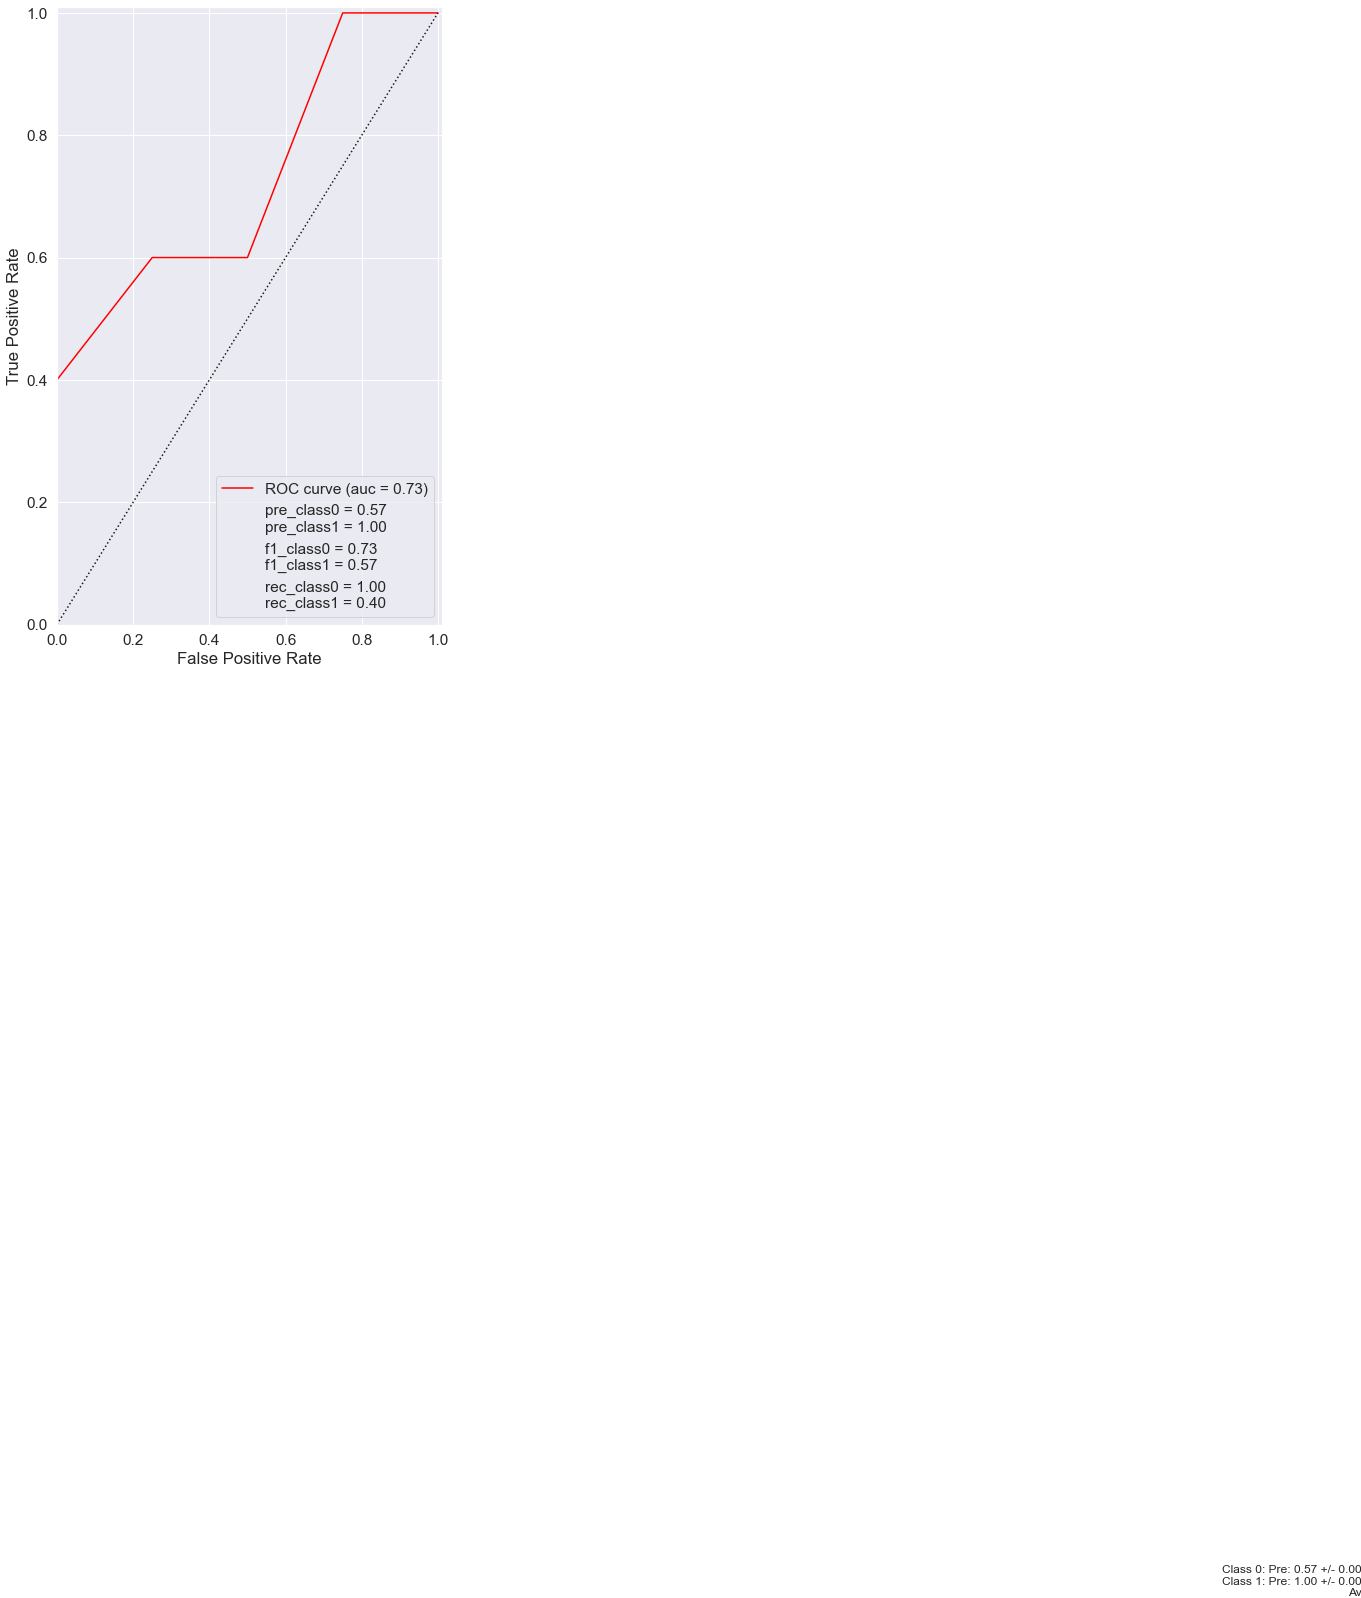


-----
Begin Gaussian Process
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

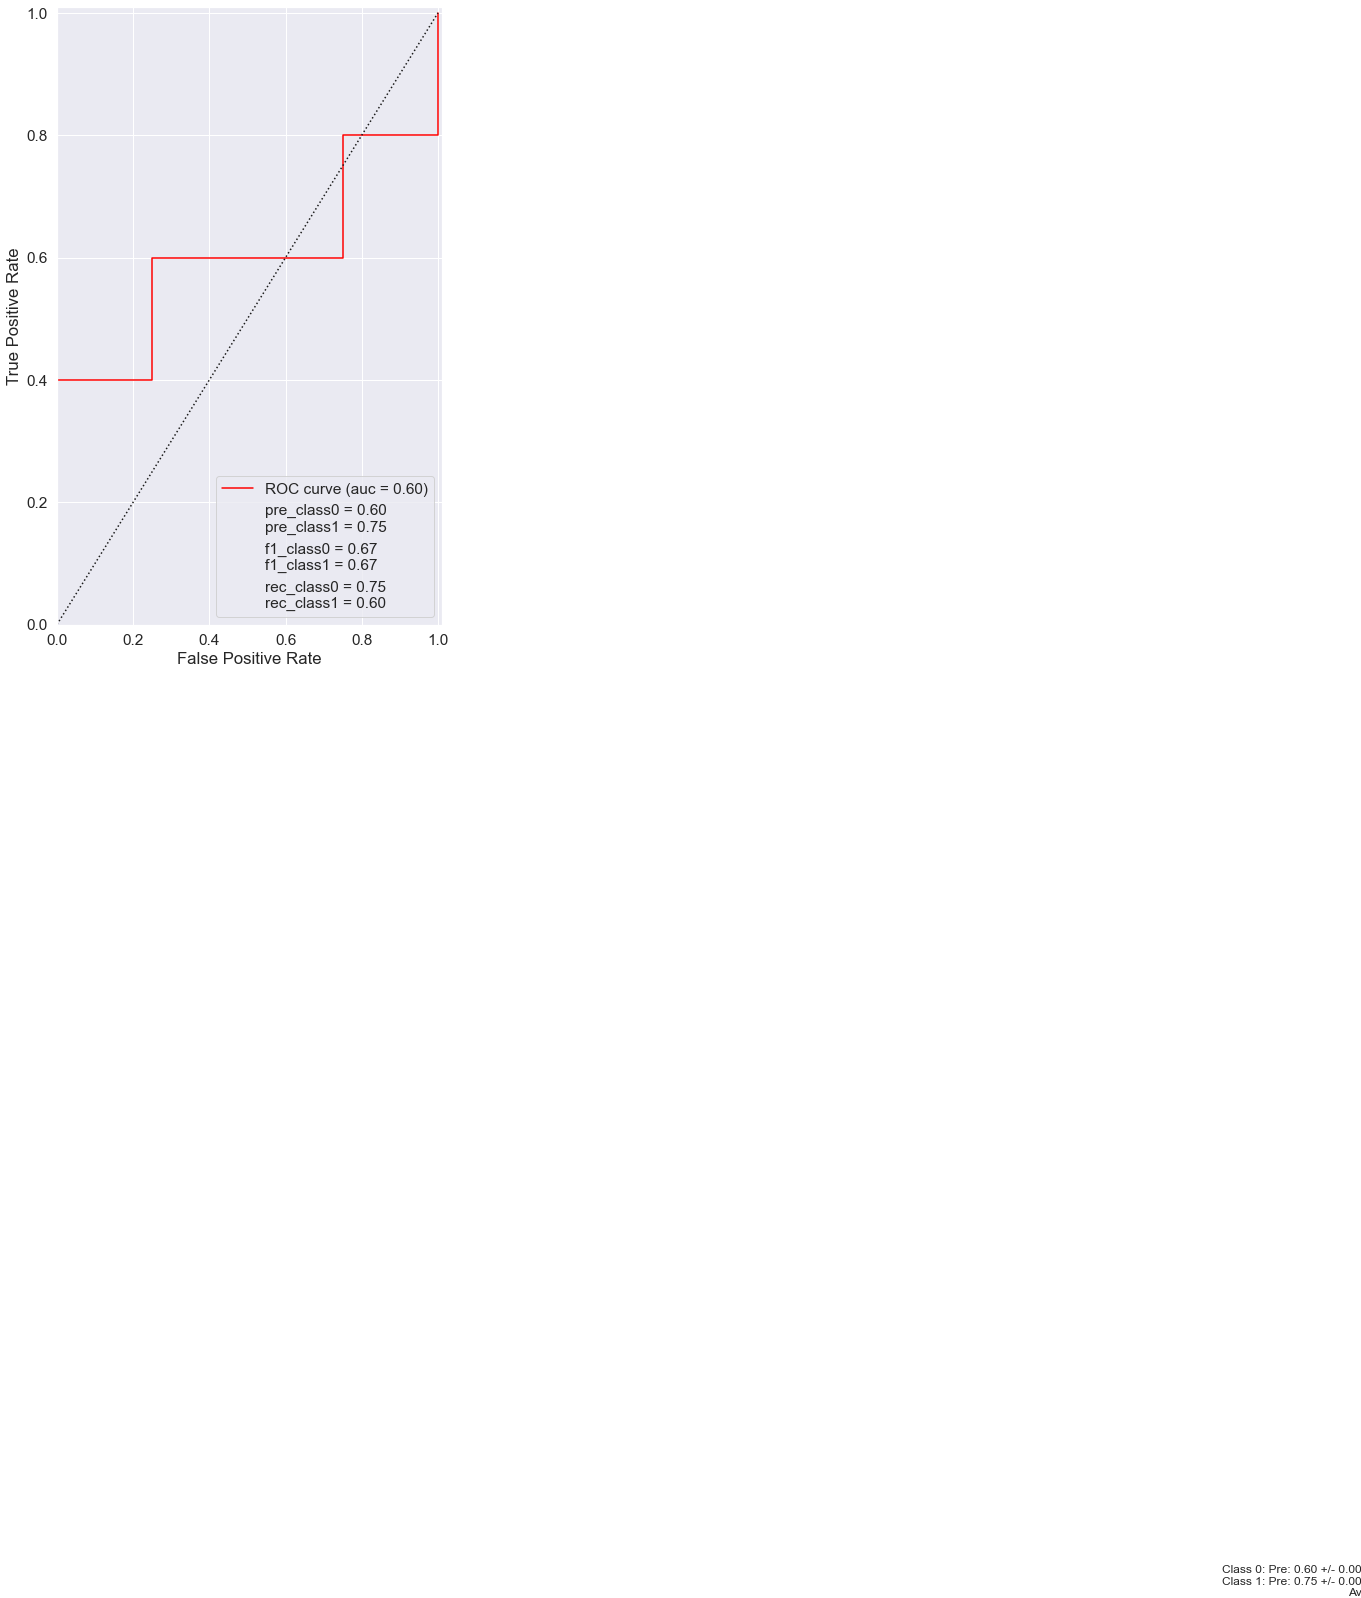


-----
Begin Decision Tree
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


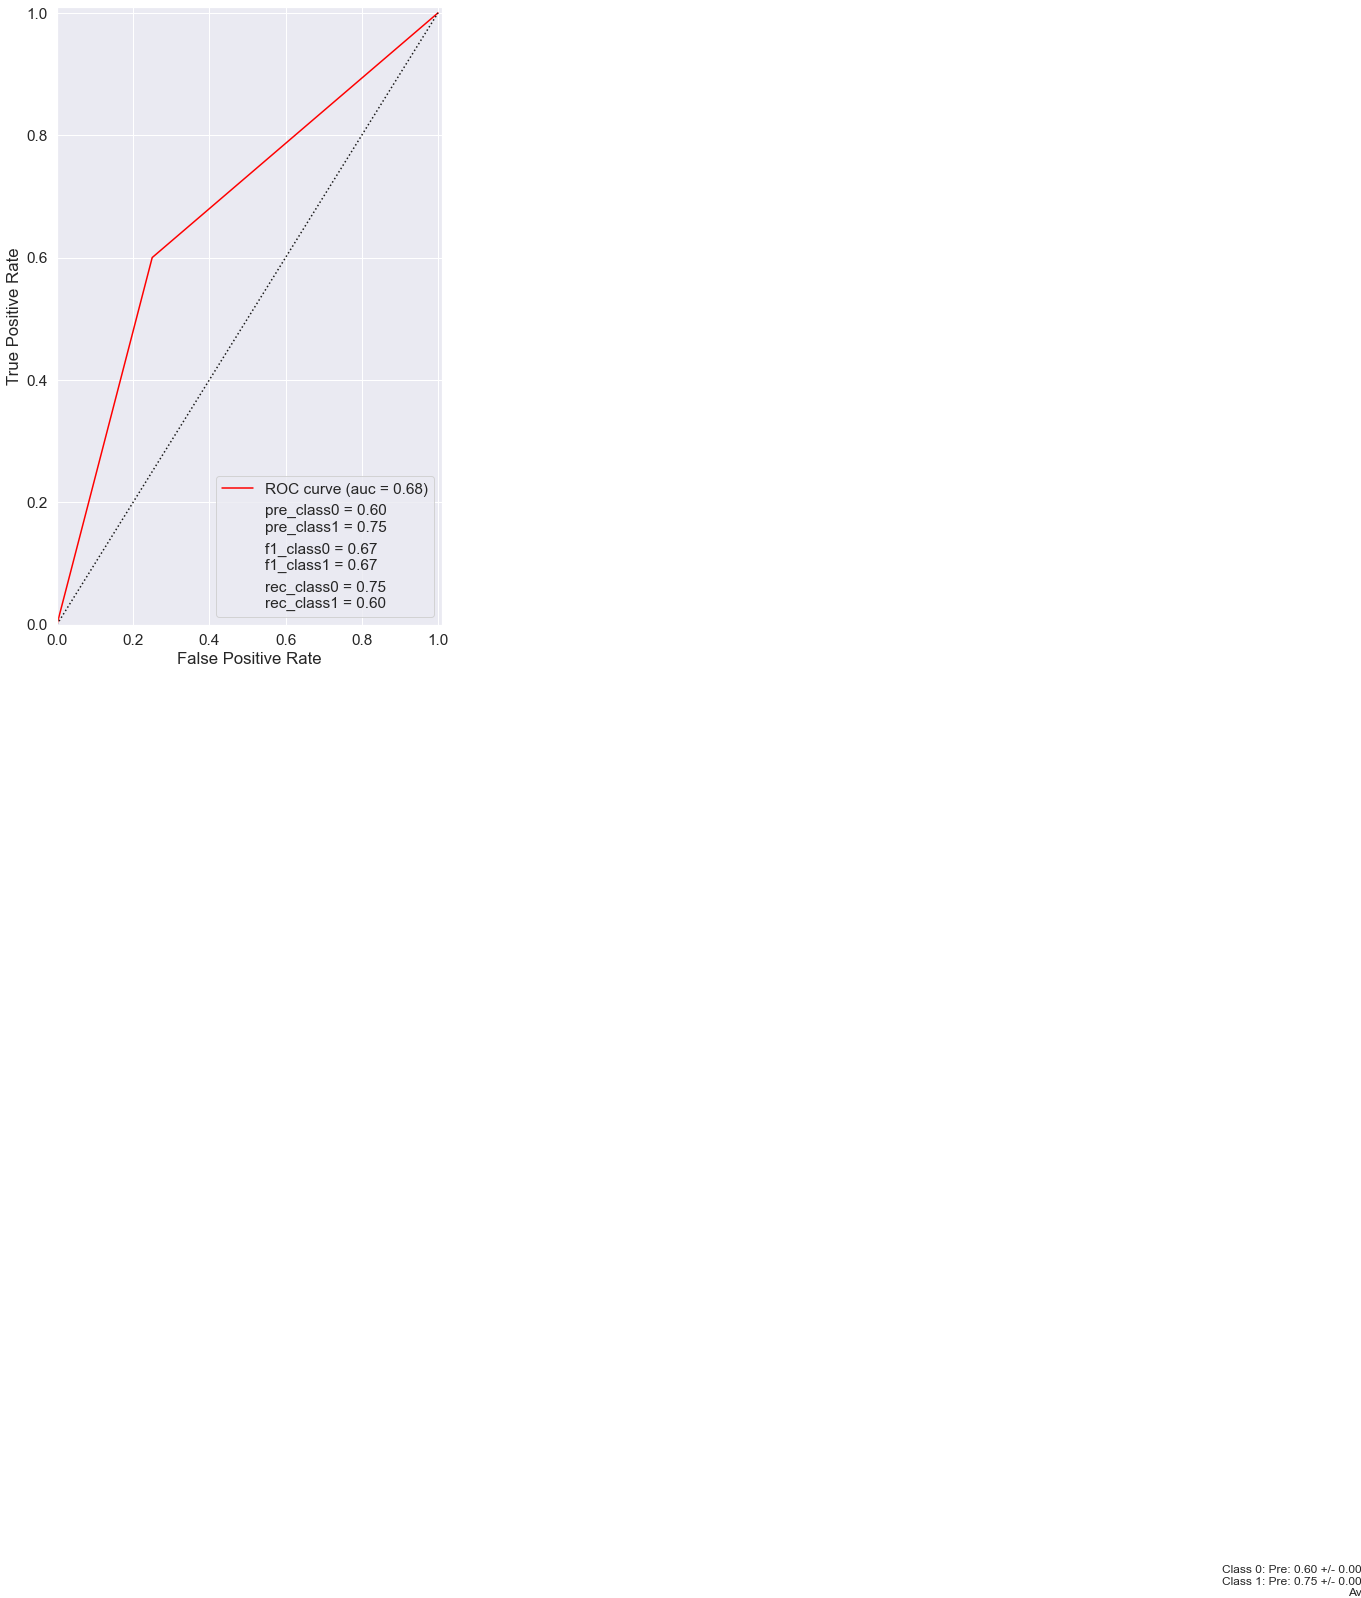


-----
Begin ExtraTreesClassifier
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

	0.7116 (+/-0.2215) for {'max_depth': 3, 'n_estimators': 100}
	0.7325 (+/-0.1594) for {'max_depth': 4, 'n_estimators': 10}
	0.6522 (+/-0.1889) for {'max_depth': 4, 'n_estimators': 20}
	0.6395 (+/-0.2511) for {'max_depth': 4, 'n_estimators': 50}
	0.7002 (+/-0.2318) for {'max_depth': 4, 'n_estimators': 100}
	0.7244 (+/-0.2186) for {'max_depth': 5, 'n_estimators': 10}
	0.6811 (+/-0.2341) for {'max_depth': 5, 'n_estimators': 20}
	0.6927 (+/-0.2230) for {'max_depth': 5, 'n_estimators': 50}
	0.7191 (+/-0.2266) for {'max_depth': 5, 'n_estimators': 100}
	0.6682 (+/-0.2254) for {'max_depth': 7, 'n_estimators': 10}
	0.6980 (+/-0.2156) for {'max_depth': 7, 'n_estimators': 20}
	0.6896 (+/-0.2189) for {'max_depth': 7, 'n_estimators': 50}
	0.7056 (+/-0.2067) for {'max_depth': 7, 'n_estimators': 100}
	0.6740 (+/-0.2699) for {'max_depth': 10, 'n_estimators': 10}
	0.6831 (+/-0.2331) for {'max_depth': 10, 'n_estimators': 20}
	0.6852 (+/-0.2145) for {'max_depth': 10, 'n_estimators': 50}
	0.7080 (+/-0.192

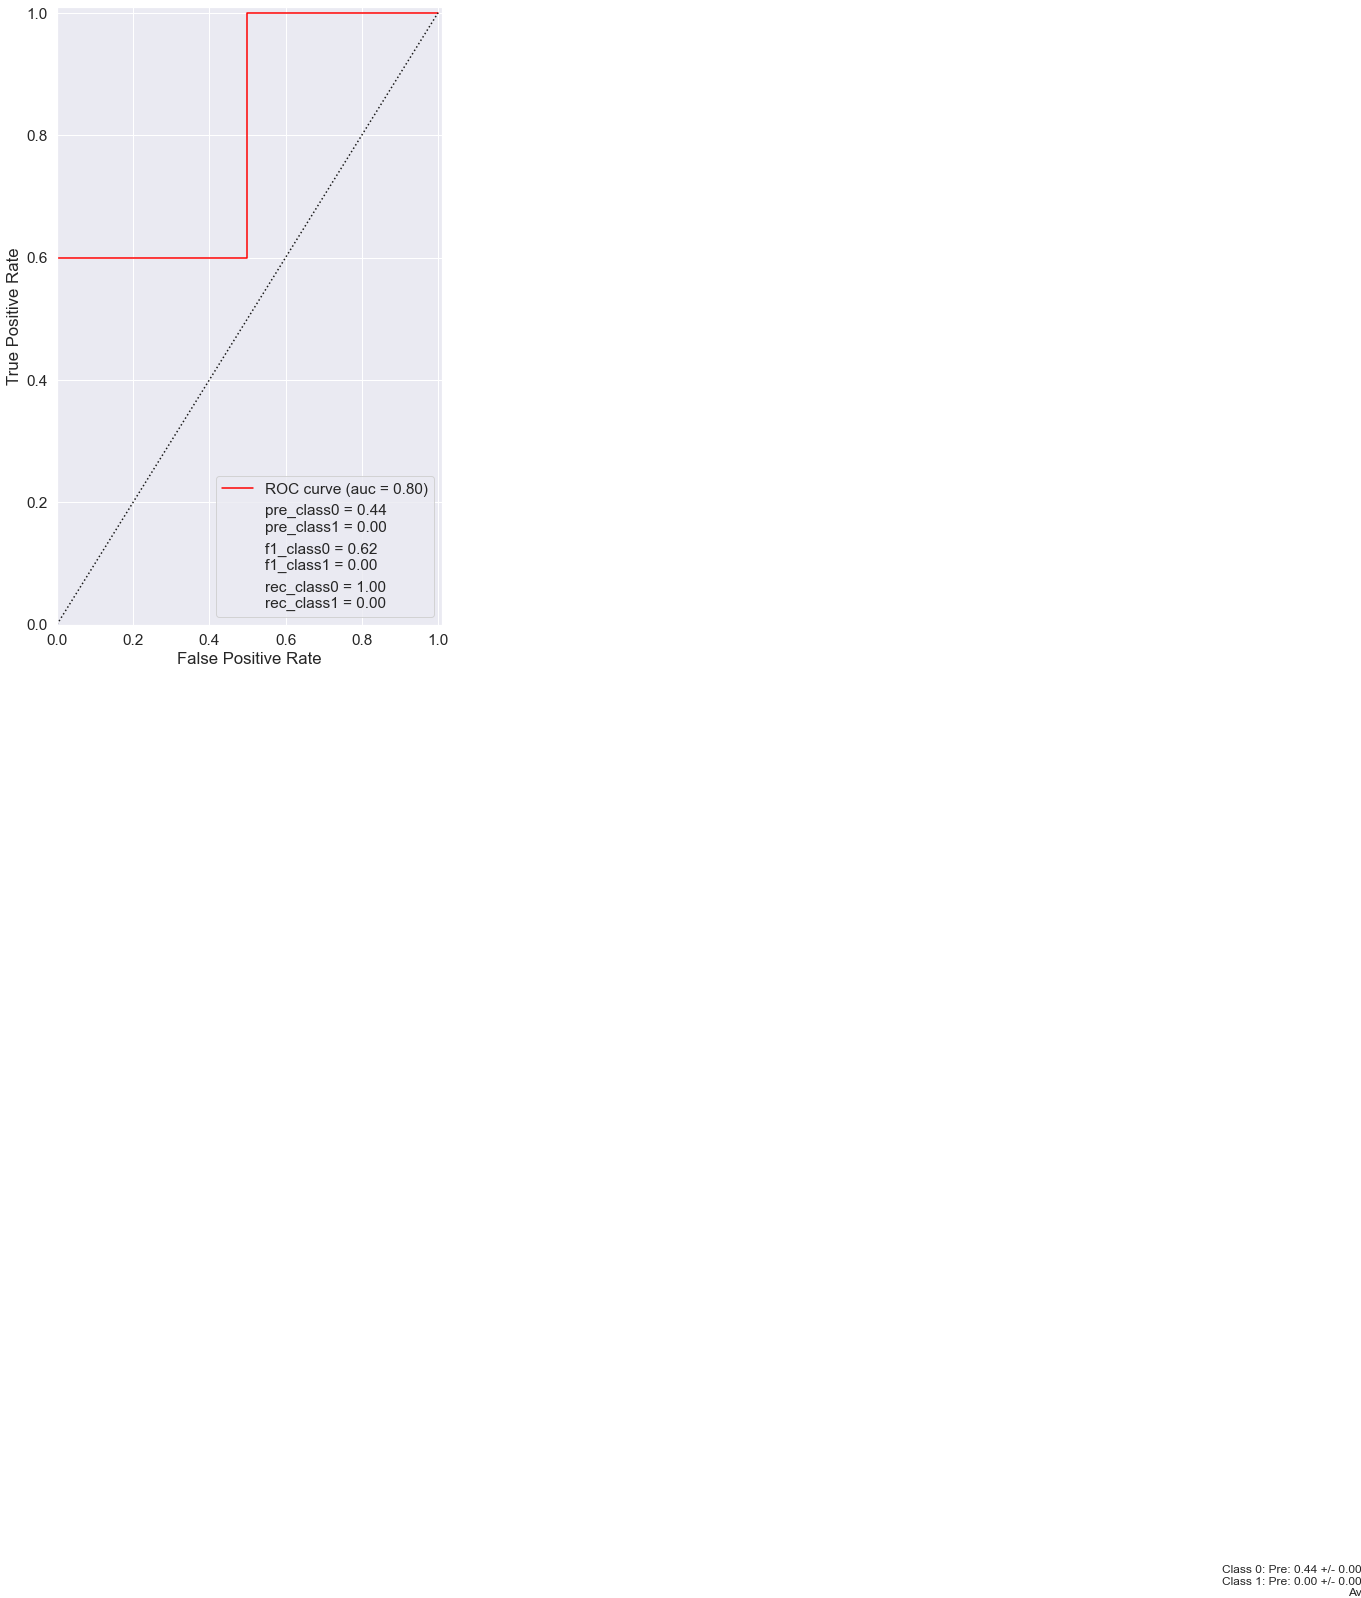


-----
Begin AdaBoost
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
	Best

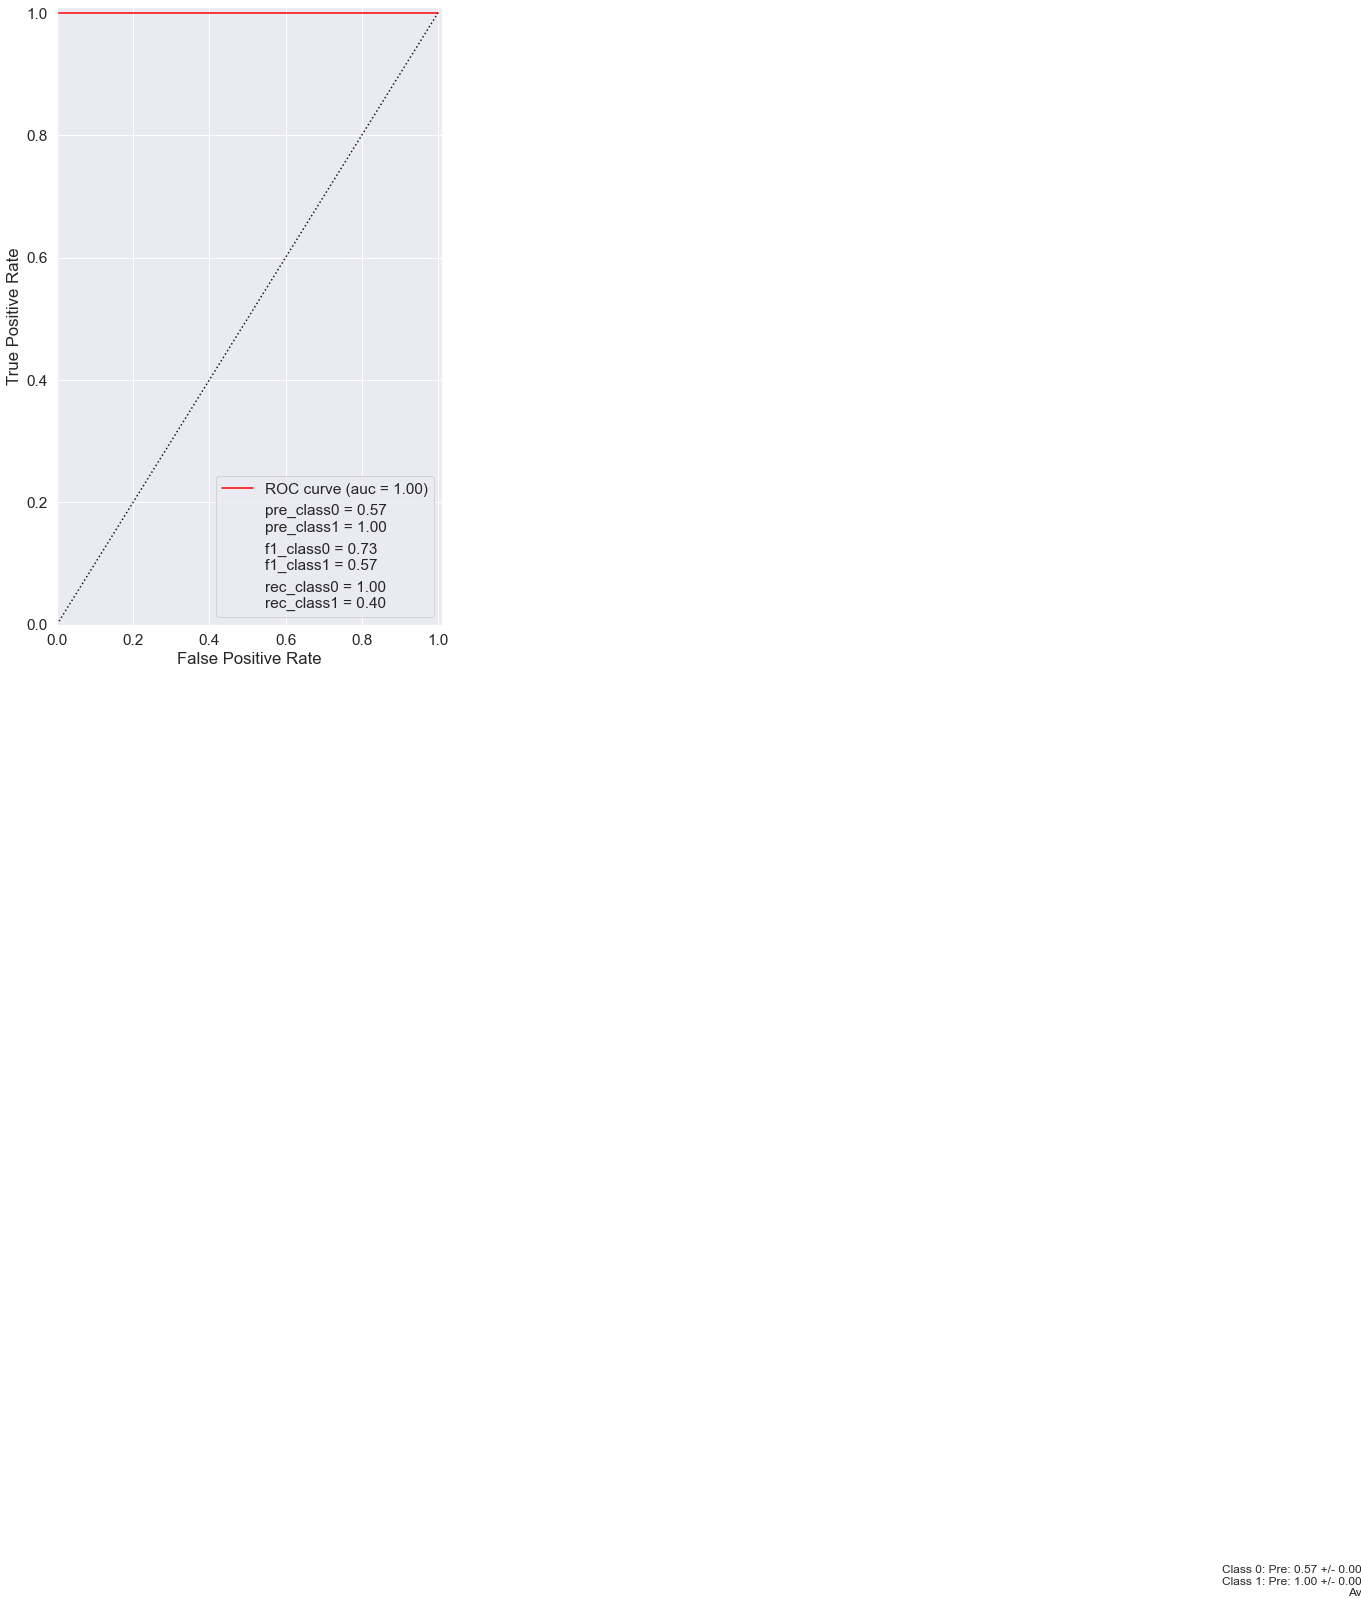


-----
Begin Logistic Regression
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

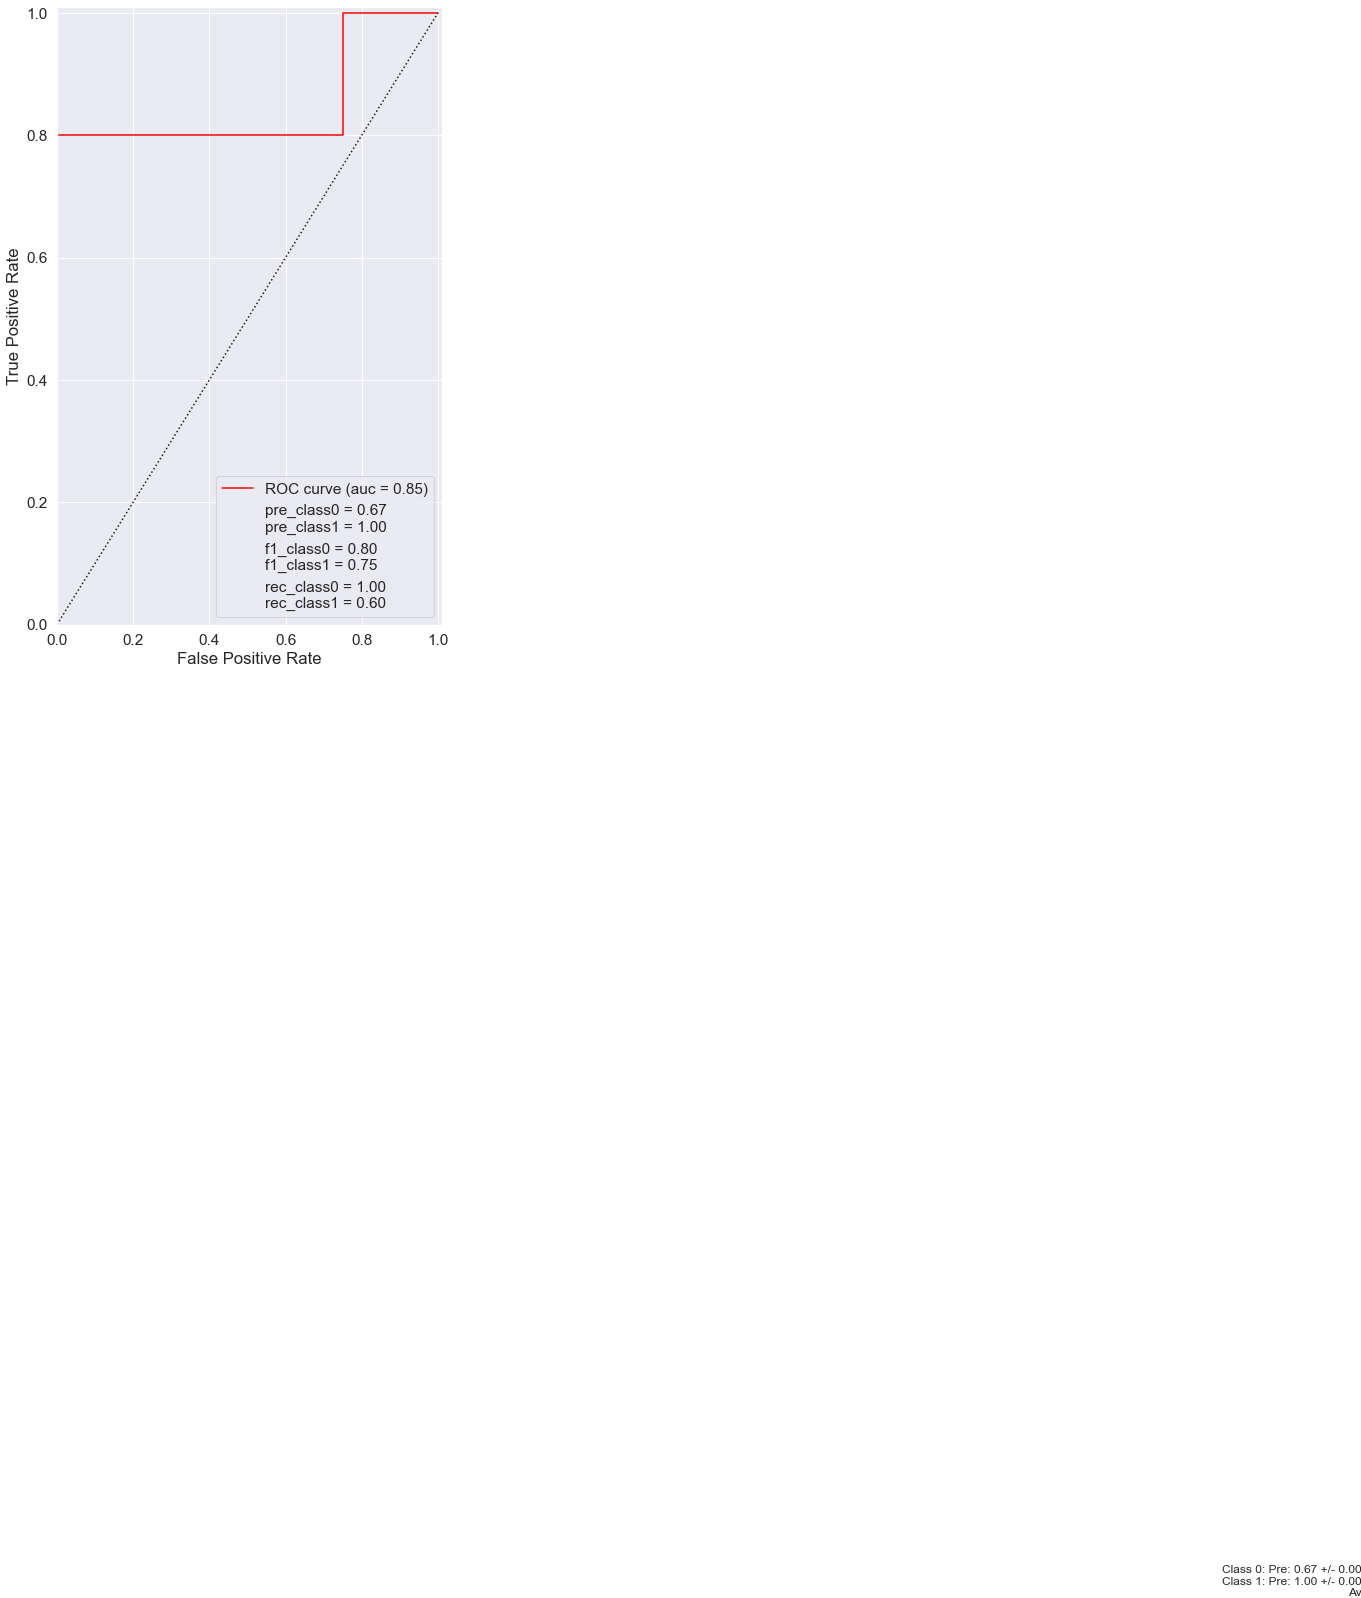

In [74]:
kfold_test_imbalenced_classifiers_with_optimization(Xtrain,Xtest, Ytrain , Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, cv=5, n_repeats=10,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]

In [75]:
directory_names = cwf.directory_names_from_classfier_names(kfold_clf_names)


Nearest_Neighbors
-------------

Reading 0.csv
Saving plot to ddg_nearest_neighbors_morderd.png
['ddg_nearest_neighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 0, 'fn': 3, 'tp': 2}
[[4 0]
 [3 2]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Gaussian_Process
-------------

Reading 0.csv
Saving plot to ddg_gaussian_process_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 3, 'fp': 1, 'fn': 2, 'tp': 3}
[[3 1]
 [2 3]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Decision_Tree
-------------

Reading 0.csv
Saving plot to ddg_decision_tree_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 3, 'fp': 1, 'fn': 2, 'tp': 3}
[[3 1]
 [2 3]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Saving plot to ddg_extratreesclassifier_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 0, 'fn': 5, 'tp': 0}
[[4 0]
 [5 0]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:185: RuntimeWarning: invalid value encountered in long_scalars
  return cm_d["tp"] / (cm_d["tp"] + cm_d["fp"])
/Users/matina/Desktop/Workflow/Modules/classification_metrics.py:221: RuntimeWarning: invalid value encountered in true_divide
  mcc_function = (cm_d["tp"] * cm_d["tn"] - cm_d["fp"] * cm_d["fn"]) / np.sqrt((cm_d["tp"] + cm_d["fp"]) * (cm_d["tp"] + cm_d["fn"]) * (cm_d["tn"] + cm_d["fp"]) * (cm_d["tn"] + cm_d["fn"]))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are 

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Logistic_Regression
-------------

Reading 0.csv
Saving plot to ddg_logistic_regression_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png', 'ddg_logistic_regression_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 0, 'fn': 2, 'tp': 3}
[[4 0]
 [2 3]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearest neighbors      &  0.666667 &          0.4 &         1.00 &  0.478091 &       1.00 &  0.632456 \\
gaussian process       &  0.666667 &          0.6 &         0.75 &  0.350000 &       0.75 &  0.670820 \\
decision tree          &  0.666667 &          0.6 &         0.75 &  0.350000 &       0.75 &  0.670820 \\
extra trees classifier &  0.444444 &          0.0 &         1.00 &       NaN &        NaN &  0.000000 \\
adaboost               &  0.666667 &          0.4 &         1.00 &  0.478091 &       1.00 &  0.632456 \\
logistic regression    &  0.777778 &          0.6 &         1.00 &  0.632456 &       1.00 &  0.774597 \\
\bottomrule
\end{tabular}



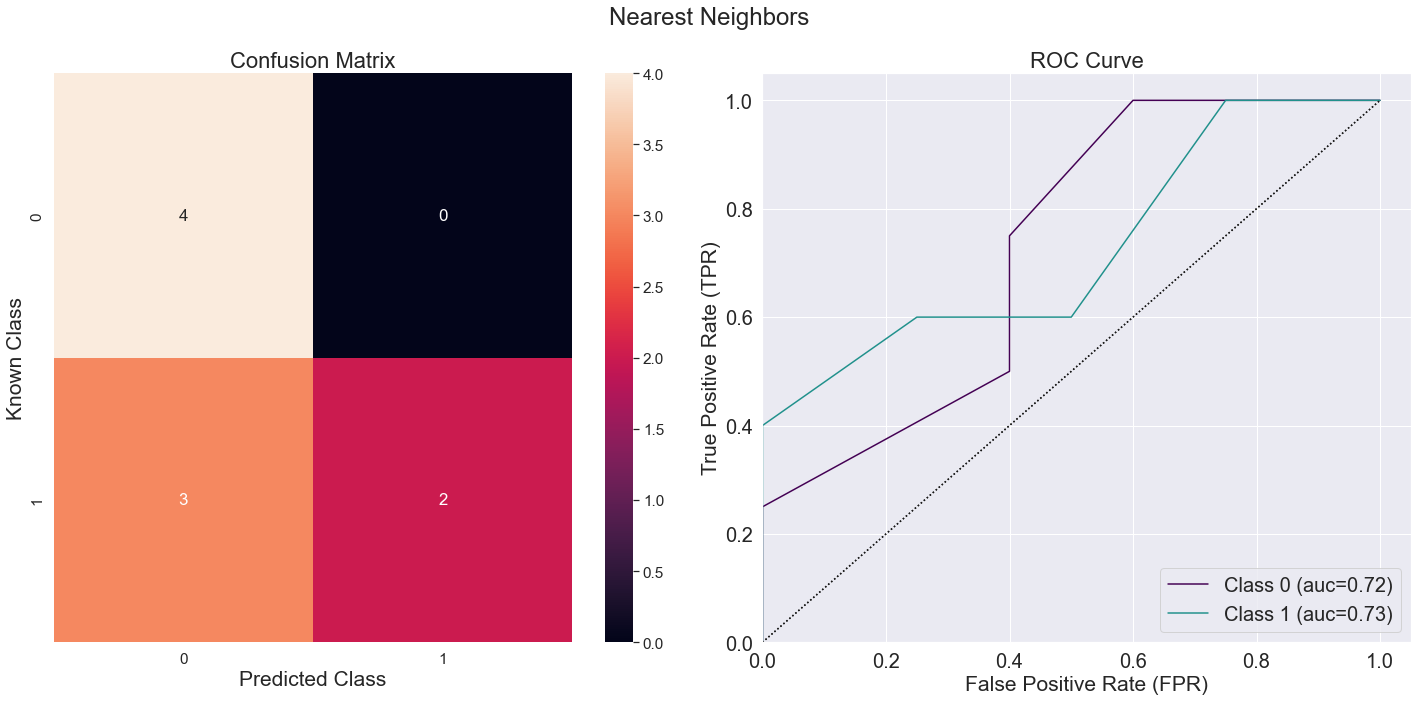

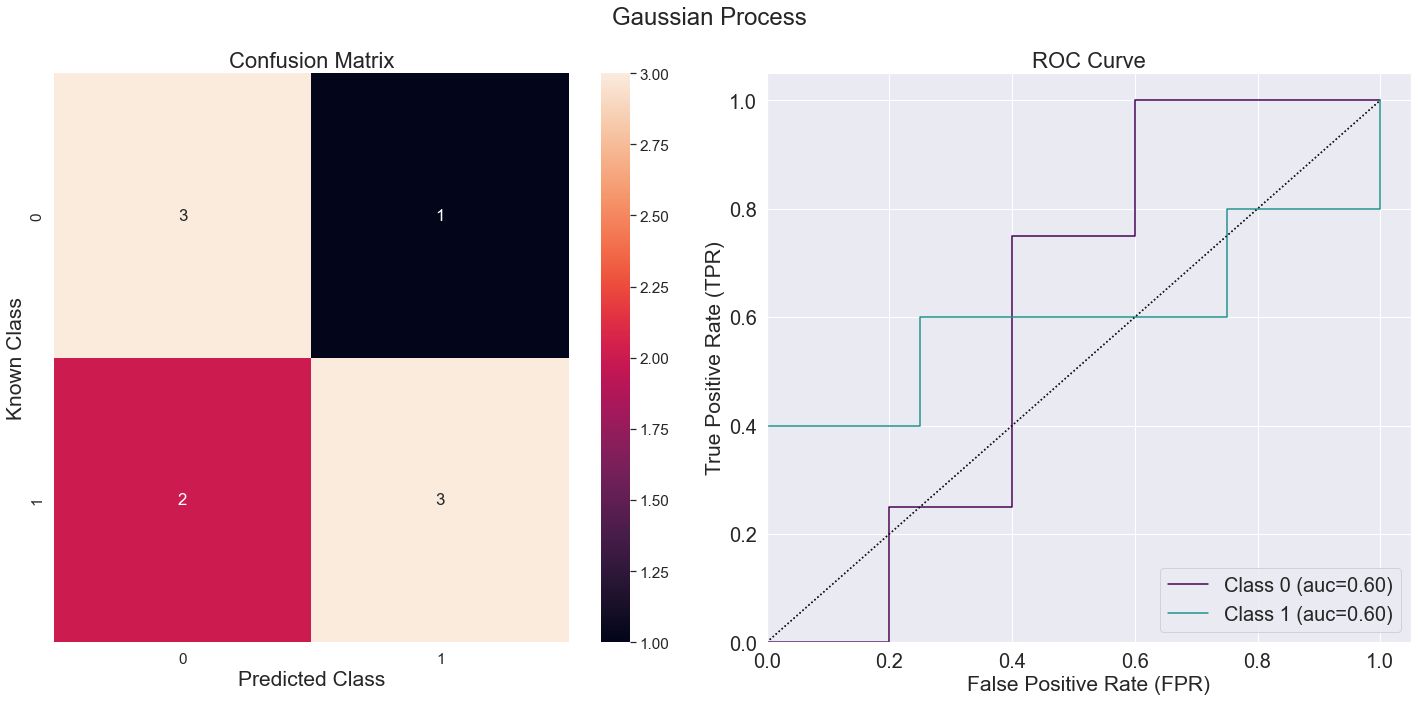

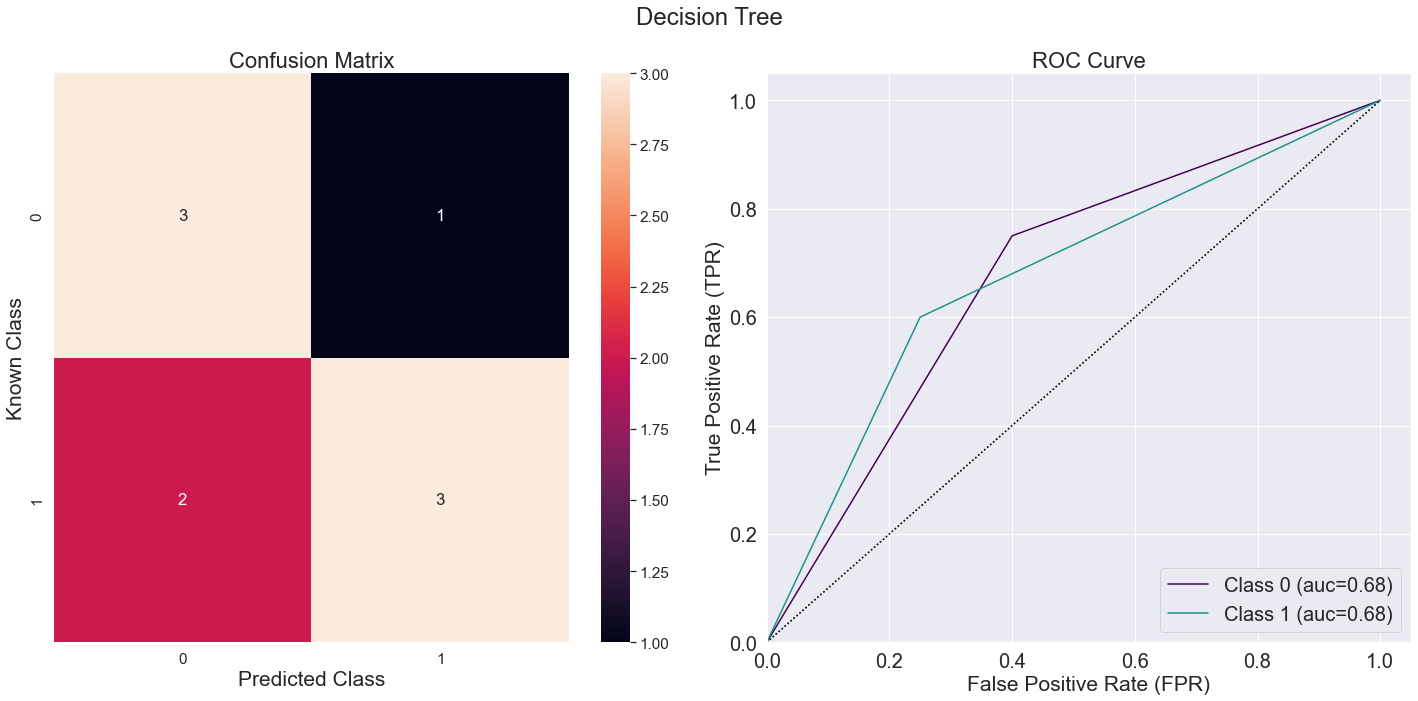

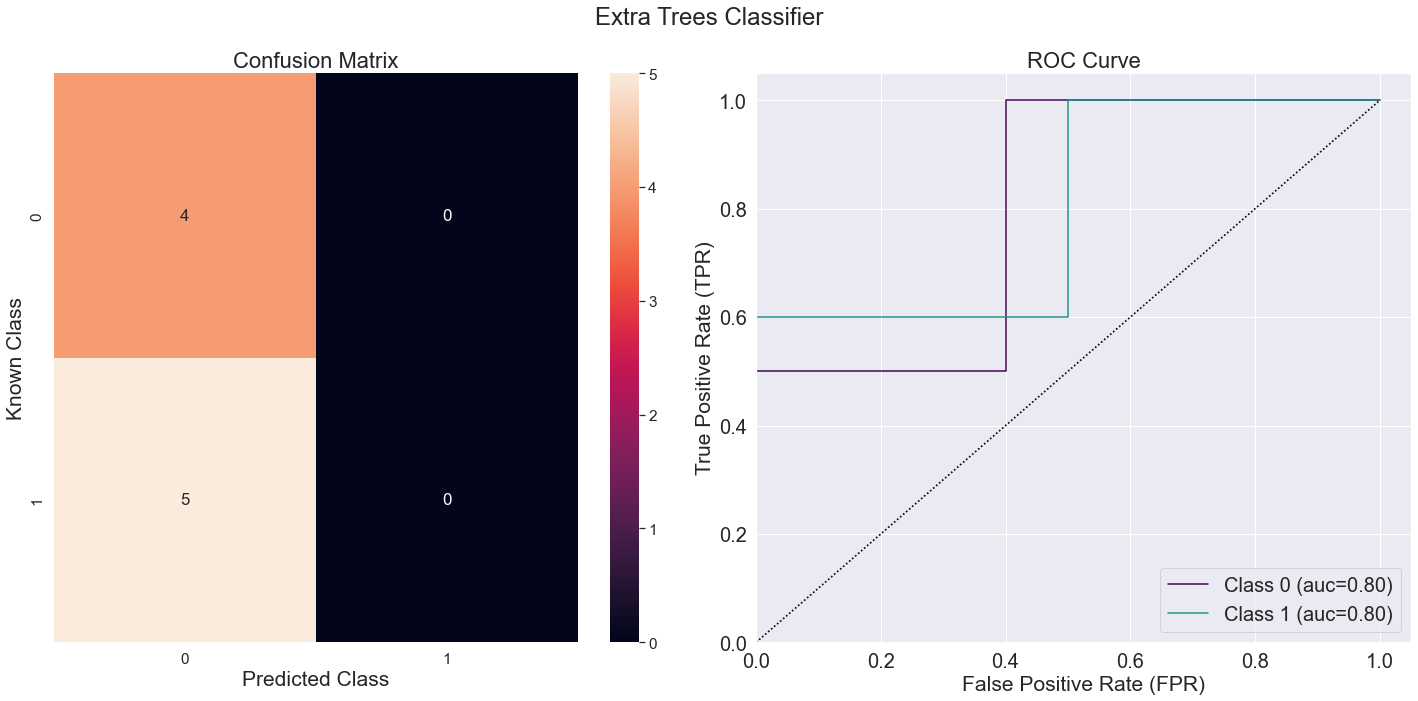

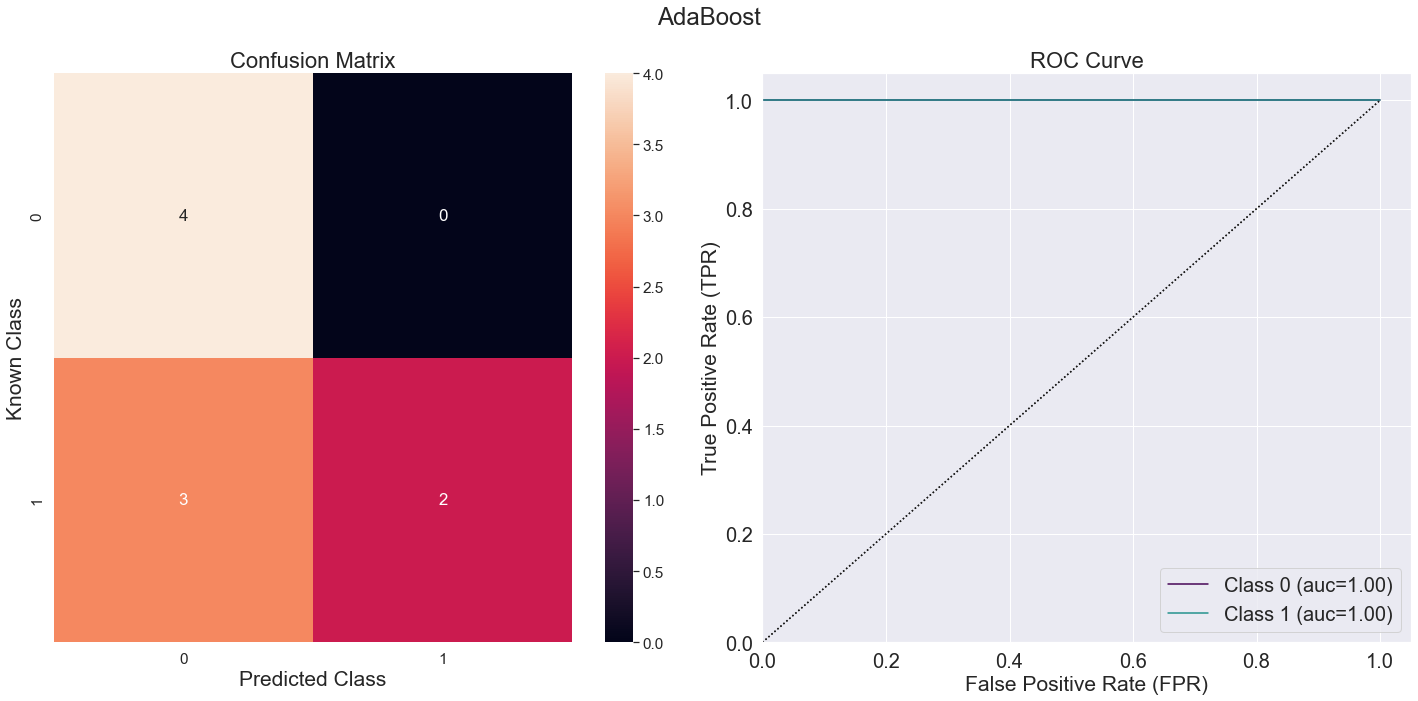

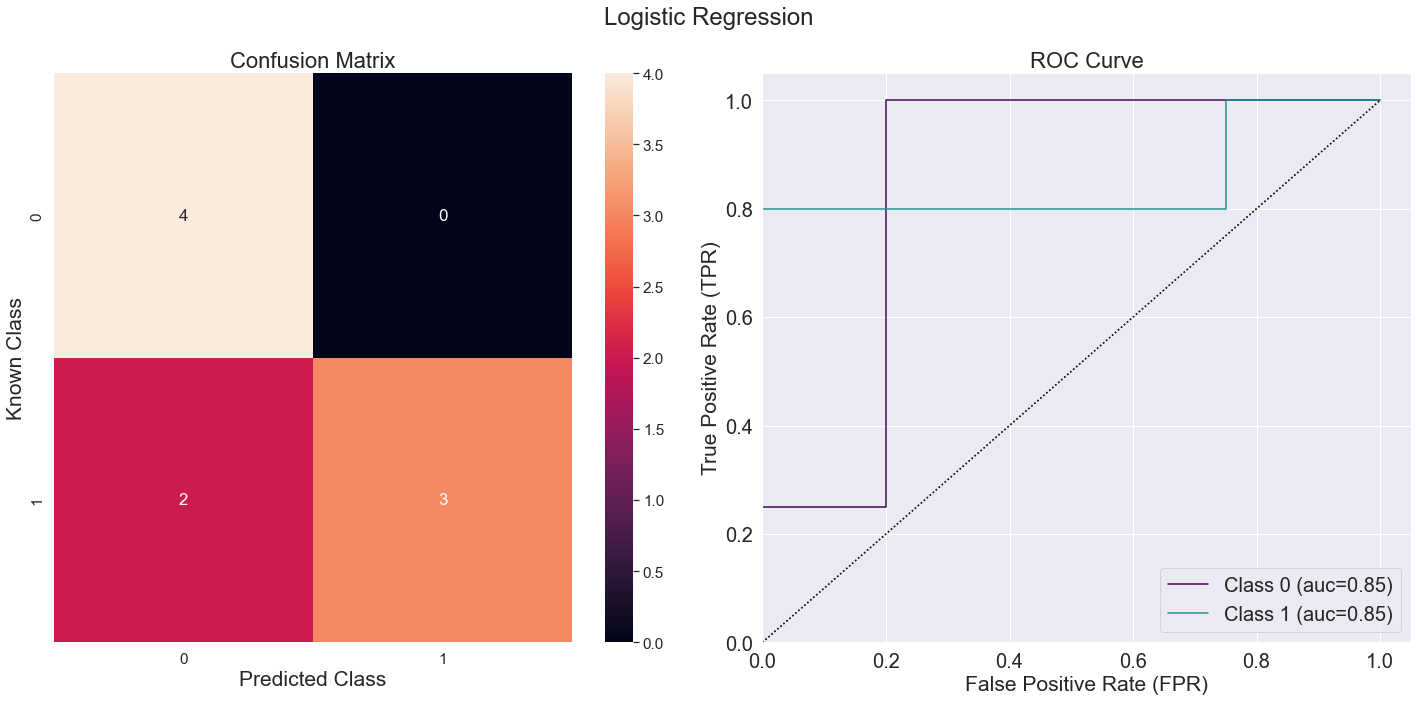

In [76]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=1)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_DFT.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:DFT_features")
log.info(df_metrics_for_paper.to_latex())

In [77]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_DFT.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600
